### Imports 

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

In [3]:
import lightgbm as lgb

In [4]:
from scipy.stats import ttest_rel

### Const and Func

In [5]:
path = Path('data/dataset/')

In [6]:
path

PosixPath('data/dataset')

In [7]:
! ls {path}

!dataset_fields_description.xlsx sample-submit-zero.csv
bs_avg_kpi.csv                   test
bs_chnn_kpi.csv                  train


In [8]:
! ls {path/'train'}

subs_bs_consumption_train.csv   subs_csi_train.csv
subs_bs_data_session_train.csv  subs_features_train.csv
subs_bs_voice_session_train.csv


In [9]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

### Loads

In [10]:
train_ids = pd.read_csv(path/'train/subs_csi_train.csv', sep=';')

In [11]:
test_ids = pd.read_csv(path/'test/subs_csi_test.csv', sep=';')

In [12]:
features_train = pd.read_csv(path/'train/subs_features_train.csv', sep=';', decimal=',', 
                              parse_dates=['SNAP_DATE'], infer_datetime_format=True, dayfirst=True)

In [13]:
features_test = pd.read_csv(path/'test/subs_features_test.csv', sep=';', decimal=',', 
                              parse_dates=['SNAP_DATE'], infer_datetime_format=True, dayfirst=True)

In [14]:
# convert to months (int)
features_train.SNAP_DATE = features_train.SNAP_DATE.dt.month

In [15]:
# convert to months (int)
features_test.SNAP_DATE = features_test.SNAP_DATE.dt.month

###  Data processing

In [15]:
train_ids.SK_ID.nunique(), features_train.SK_ID.nunique()

(4222, 4222)

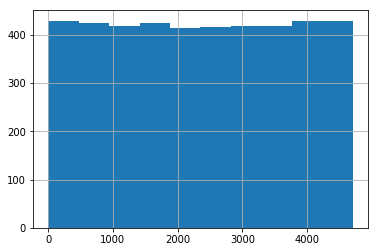

In [16]:
train_ids.SK_ID.hist();

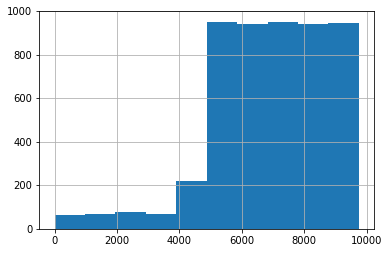

In [17]:
test_ids.SK_ID.hist();

#### Id-based validation

In [18]:
features_test.SNAP_DATE.unique()

array([10,  7,  6,  1,  8,  4,  5, 11,  9,  2, 12,  3])

In [227]:
raw_train = features_train[features_train.SNAP_DATE.isin([1,2,3,4,5])].copy()
raw_test = features_test[features_test.SNAP_DATE.isin([1,2,3,4])].copy()

In [367]:
raw_train_other = features_train[features_train.SNAP_DATE.isin([4,5])].copy()

### Aggregation

In [228]:
raw_train.head()

SNAP_DATE  COM_CAT#1  SK_ID  COM_CAT#2  COM_CAT#3  BASE_TYPE  ACT  \
570          1          4    238         75          5          2    1   
571          1          4   1293         70          5          2    1   
572          1          4   1620         47          5          2    1   
573          1          4   1393         38          5          2    1   
574          1          4    624         36          5          2    1   

     ARPU_GROUP  COM_CAT#7  COM_CAT#8     ...      COM_CAT#25  COM_CAT#26  \
570         8.0          1      945.0     ...               1           1   
571         6.0          1      720.0     ...               1           1   
572         7.0          1     1620.0     ...               1           1   
573         6.0          3     1399.0     ...               1           1   
574        10.0          1     1627.0     ...               1           1   

     COM_CAT#27  COM_CAT#28  COM_CAT#29  COM_CAT#30  COM_CAT#31  COM_CAT#32  \
570    0.009408    0.016091    0.000000         0.0    0.043079    0.027579   
571    0.001875    0.001785    0.004100         0.0    0.060689    0.027579   
572    0.005866    0.002898    0.000000         0.0    0.287902    0.027579   
573    0.020422    0.012353    0.000000         0.0    0.025244    0.027579   
574    0.016859    0.005389    0.113934         0.0    0.039788    0.027579   

     COM_CAT#33  COM_CAT#34  
570    0.103896         3.0  
571    0.103896         7.0  
572    0.103896         1.0  
573    0.103896         3.0  
574    0.103896         2.0  

[5 rows x 36 columns]

In [229]:
for df in (raw_train, raw_test):
    df.drop('SNAP_DATE', axis=1, inplace=True)

In [230]:
for df in (raw_train, raw_test):
    print('====')
    for n, c in df.iteritems():
        if c.nunique() < 10:
            print(n, '-->', c.nunique(), c.dtype)

====
COM_CAT#1 --> 8 int64
BASE_TYPE --> 2 int64
ACT --> 2 int64
COM_CAT#7 --> 9 int64
DEVICE_TYPE_ID --> 7 float64
INTERNET_TYPE_ID --> 3 float64
COM_CAT#24 --> 8 object
COM_CAT#25 --> 2 int64
COM_CAT#26 --> 2 int64
====
COM_CAT#1 --> 8 int64
BASE_TYPE --> 2 int64
ACT --> 2 int64
COM_CAT#7 --> 9 int64
DEVICE_TYPE_ID --> 8 float64
INTERNET_TYPE_ID --> 3 float64
COM_CAT#24 --> 7 object
COM_CAT#25 --> 2 int64
COM_CAT#26 --> 2 int64


In [231]:
train_cats(raw_train)
apply_cats(raw_test, raw_train)

In [232]:
tr_gr = raw_train.groupby('SK_ID', as_index=False).agg(['size', 'mean', 'max', 'min'])
test_gr = raw_test.groupby('SK_ID', as_index=False).agg(['size', 'mean', 'max', 'min'])

In [233]:
for df in (tr_gr, test_gr):
    df.columns = ['_'.join(c) for c in df.columns]

In [234]:
# add contact date and labels
tr_gr = pd.merge(tr_gr, train_ids, on='SK_ID')

In [235]:
test_gr = pd.merge(test_ids, test_gr, on='SK_ID', how='left')

In [236]:
for df in (tr_gr, test_gr):
    df['CONTACT_DATE'] = pd.to_datetime(df['CONTACT_DATE'], format='%d.%m').dt.day

In [237]:
(tr_gr.shape,test_gr.shape)

((4213, 135), (5221, 134))

####  Aggregation for other set to get best set of months

In [368]:
raw_train_other.drop('SNAP_DATE', axis=1, inplace=True)

In [369]:
train_cats(raw_train_other)

In [370]:
tr_gr_other = raw_train_other.groupby('SK_ID', as_index=False).agg(['size', 'mean', 'max', 'min'])

In [371]:
tr_gr_other.columns = ['_'.join(c) for c in tr_gr_other.columns]

In [372]:
# add contact date and labels
tr_gr_other = pd.merge(tr_gr_other, train_ids, on='SK_ID')

In [373]:
tr_gr_other['CONTACT_DATE'] = pd.to_datetime(tr_gr_other['CONTACT_DATE'], format='%d.%m').dt.day

In [374]:
(tr_gr.shape,tr_gr_other.shape)

((4213, 135), (4201, 135))

In [375]:
tr_gr_other.head()

SK_ID  COM_CAT#1_size  COM_CAT#1_mean  COM_CAT#1_max  COM_CAT#1_min  \
0      2               2               7              7              7   
1      3               2               4              4              4   
2      4               2               8              8              8   
3      5               2               3              3              3   
4      6               2               5              5              5   

   COM_CAT#2_size  COM_CAT#2_mean  COM_CAT#2_max  COM_CAT#2_min  \
0               2            77.0             77             77   
1               2            51.0             51             51   
2               2            12.0             12             12   
3               2            79.0             79             79   
4               2            48.0             48             48   

   COM_CAT#3_size      ...       COM_CAT#33_size  COM_CAT#33_mean  \
0               2      ...                     2         0.103896   
1               2      ...                     2         0.103896   
2               2      ...                     2         0.103896   
3               2      ...                     2         0.103896   
4               2      ...                     2         0.103896   

   COM_CAT#33_max  COM_CAT#33_min  COM_CAT#34_size  COM_CAT#34_mean  \
0        0.103896        0.103896                2              9.0   
1        0.103896        0.103896                2              9.0   
2        0.103896        0.103896                2              3.0   
3        0.103896        0.103896                2              2.0   
4        0.103896        0.103896                2              3.0   

   COM_CAT#34_max  COM_CAT#34_min  CSI  CONTACT_DATE  
0             9.0             9.0    0             4  
1             9.0             9.0    0            21  
2             3.0             3.0    0            27  
3             2.0             2.0    0             8  
4             3.0             3.0    1             6  

[5 rows x 135 columns]

### Train

In [255]:
df, y, nas = proc_df(tr_gr.drop(['SK_ID'], axis=1), 'CSI')

In [376]:
df_other, y_other, _ = proc_df(tr_gr_other.drop(['SK_ID'], axis=1), 'CSI')

In [239]:
test, _, _ = proc_df(test_gr.drop(['SK_ID'], axis=1), na_dict=nas)

In [377]:
m = RandomForestClassifier(n_jobs=-1, n_estimators=10)
m.fit(df_other, y_other)
m.score(df_other, y_other)

0.9761961437752916

In [241]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 400
n_trn = len(df)-n_valid
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

In [242]:
raw_tr, raw_val = split_vals(tr_gr.drop(['SK_ID'], axis=1), 2100)

In [243]:
X_train.shape, X_valid.shape, raw_tr.shape

((3813, 145), (400, 145), (2100, 134))

In [244]:
def print_score(m):
    res = [metrics.roc_auc_score(y_train, m.predict_proba(X_train)[:,1]), 
           metrics.roc_auc_score(y_valid, m.predict_proba(X_valid)[:,1]),
           m.score(X_train, y_train), m.score(X_valid, y_valid)]
    
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [245]:
m = RandomForestClassifier(n_jobs=-1, n_estimators=100, min_samples_leaf=12, max_features=0.8, 
                            oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.994582341654261, 0.5347279900332227, 0.8429058484133228, 0.86, 0.8429058484133228]


In [246]:
m = lgb.LGBMClassifier()
m.fit(X_train, y_train)
print_score(m)

[0.9999470181063024, 0.5350913621262459, 0.971938106477839, 0.8525]


### Feature Importance 

In [134]:
fi = rf_feat_importance(m, X_train)

In [135]:
fi[:10]

cols  imp
5       COM_CAT#2_mean  107
132       CONTACT_DATE   94
119     COM_CAT#31_min   92
61           COST_mean   80
118     COM_CAT#31_max   79
53   RENT_CHANNEL_mean   77
103     COM_CAT#27_min   76
91      COM_CAT#23_min   76
54    RENT_CHANNEL_max   74
90      COM_CAT#23_max   71

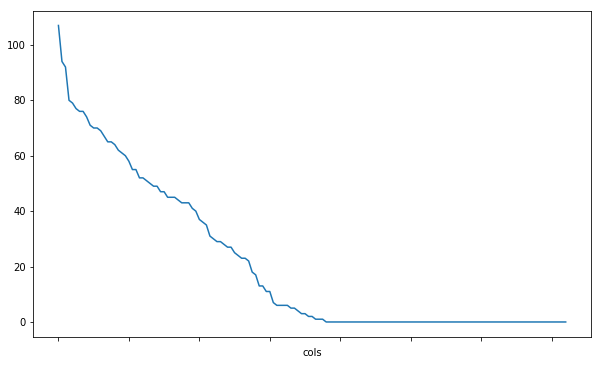

In [136]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [137]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

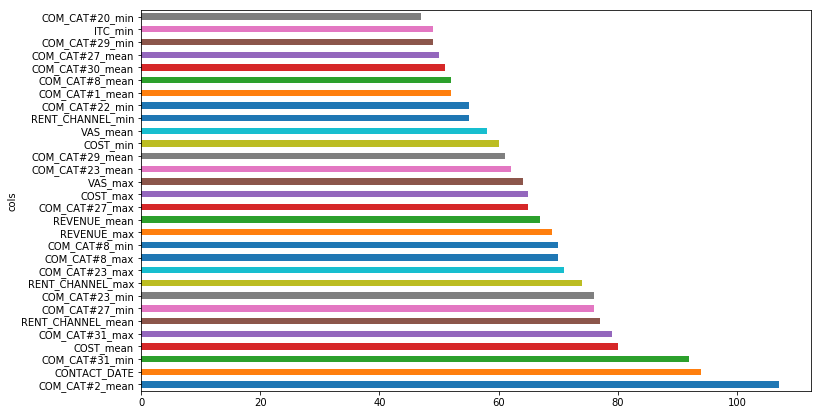

In [138]:
plot_fi(fi[:30]);

In [195]:
fi.describe()

imp
count  145.000000
mean    20.689655
std     27.633644
min      0.000000
25%      0.000000
50%      2.000000
75%     43.000000
max    107.000000

In [211]:
to_keep = fi[fi.imp>20].cols; len(to_keep)

55

In [212]:
df_keep = df[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

#### Hierarchical Clustering 

In [213]:
from scipy.cluster import hierarchy as hc

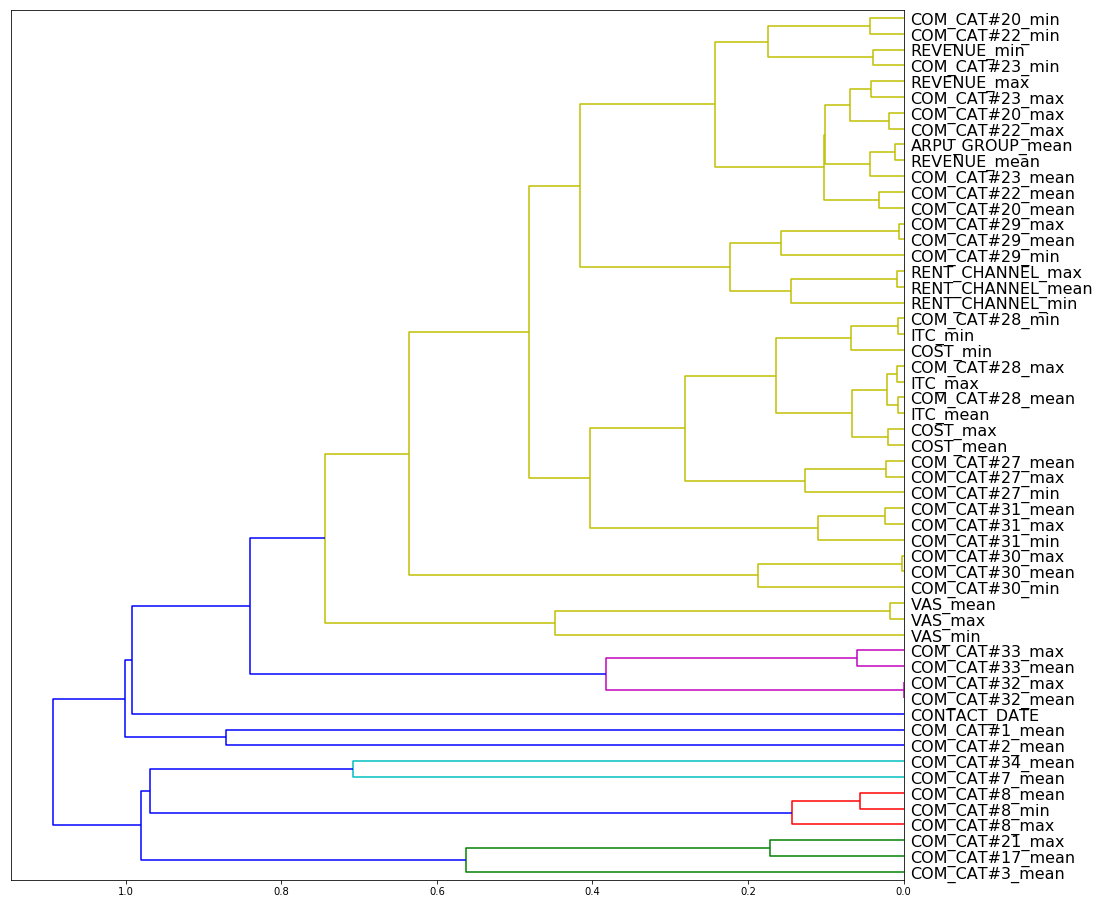

In [214]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,16))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

#### Univariate plots on test - valid 

In [52]:
from featexp import get_univariate_plots

                                       Plots for COM_CAT#2_mean                                       
                                           Train data plots                                           


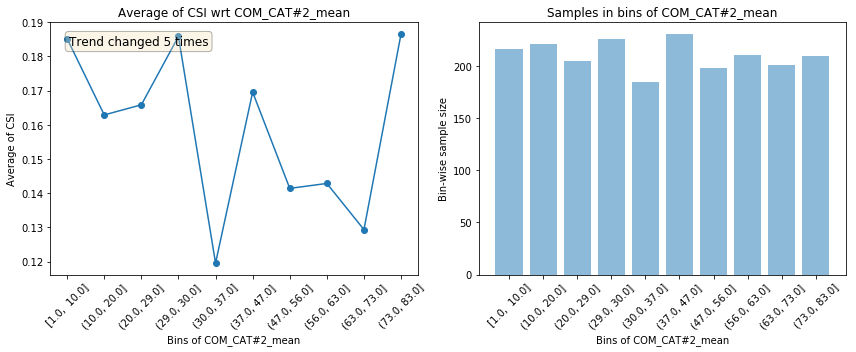

                                           Test data plots                                            


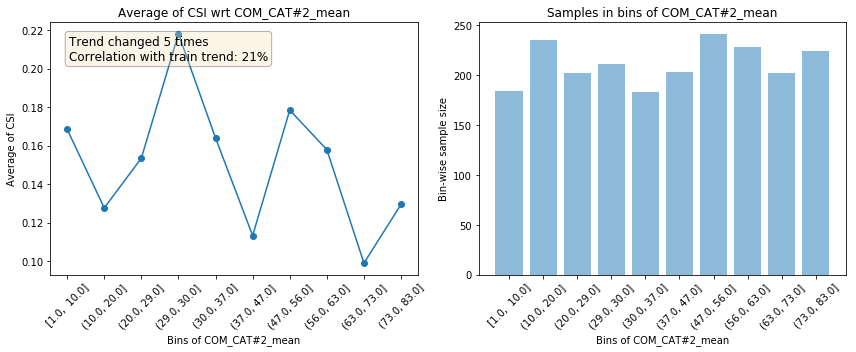

--------------------------------------------------------------------------------------------------------------


                                        Plots for CONTACT_DATE                                        
                                           Train data plots                                           


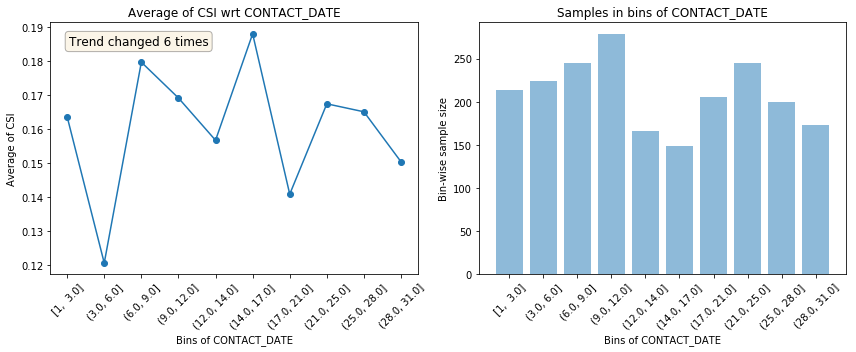

                                           Test data plots                                            


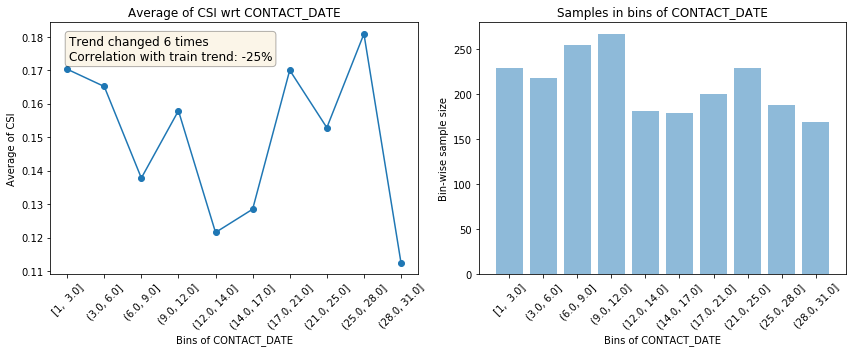

--------------------------------------------------------------------------------------------------------------


                                       Plots for COM_CAT#31_min                                       
                                           Train data plots                                           


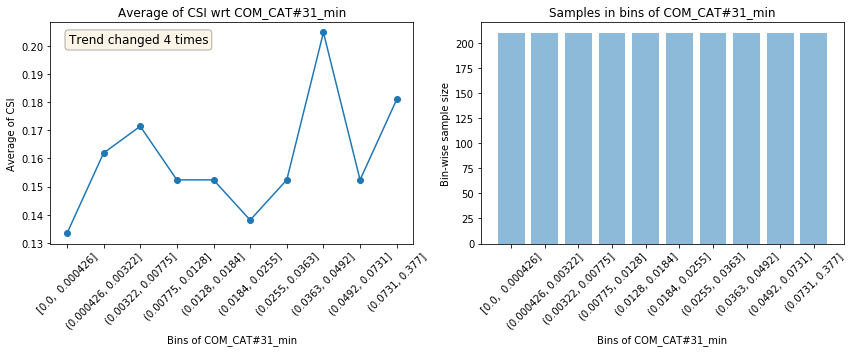

                                           Test data plots                                            


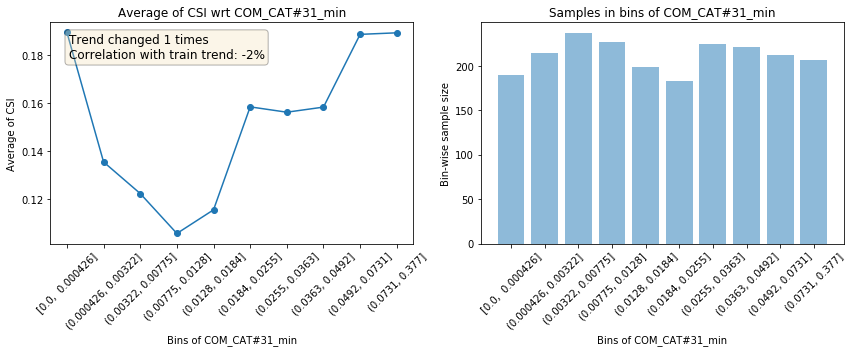

--------------------------------------------------------------------------------------------------------------


                                         Plots for COST_mean                                          
                                           Train data plots                                           


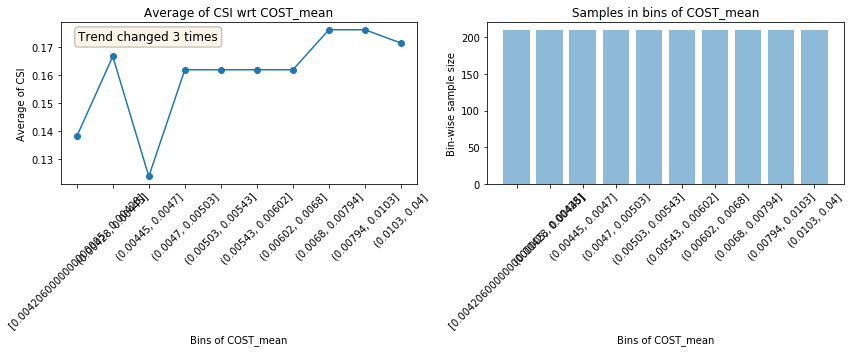

                                           Test data plots                                            


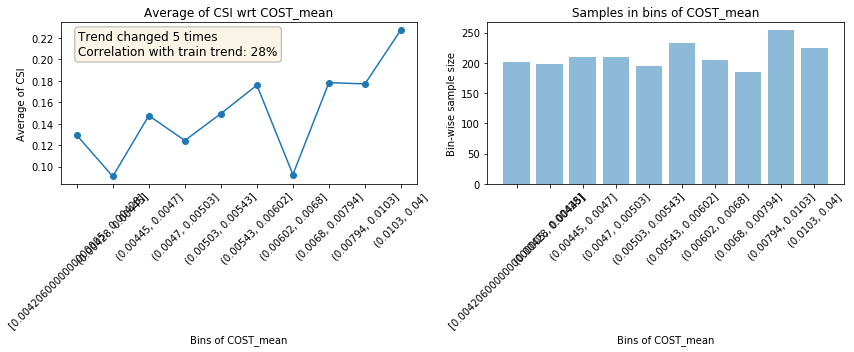

--------------------------------------------------------------------------------------------------------------


                                       Plots for COM_CAT#31_max                                       
                                           Train data plots                                           


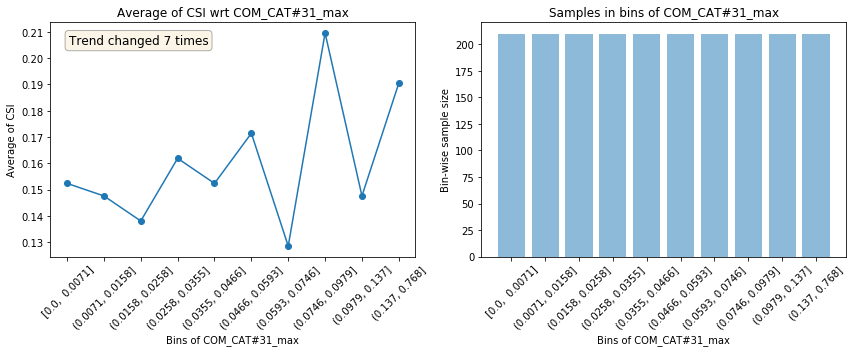

                                           Test data plots                                            


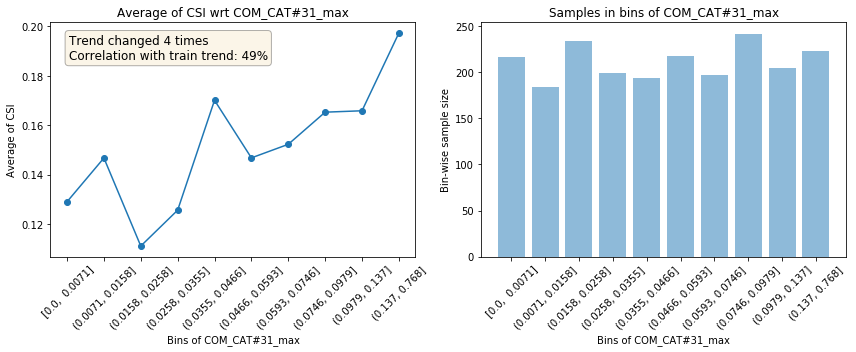

--------------------------------------------------------------------------------------------------------------


                                     Plots for RENT_CHANNEL_mean                                      
                                           Train data plots                                           


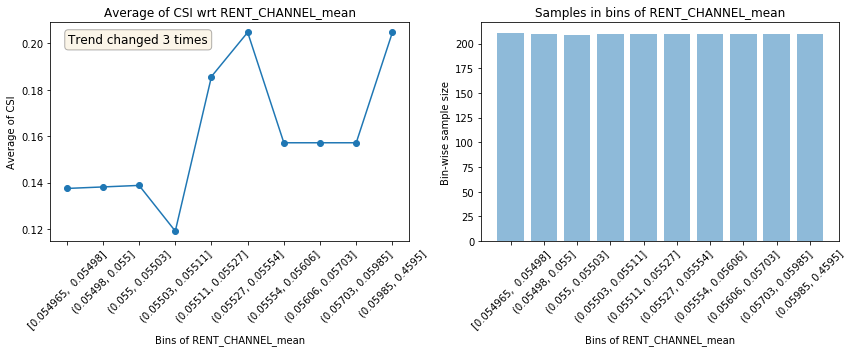

                                           Test data plots                                            


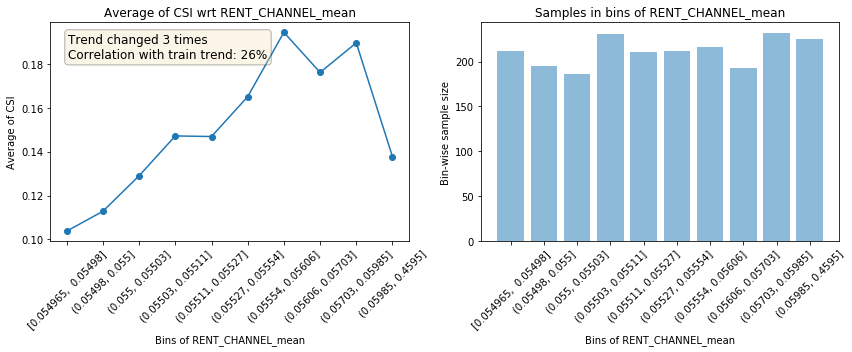

--------------------------------------------------------------------------------------------------------------


                                       Plots for COM_CAT#27_min                                       
                                           Train data plots                                           


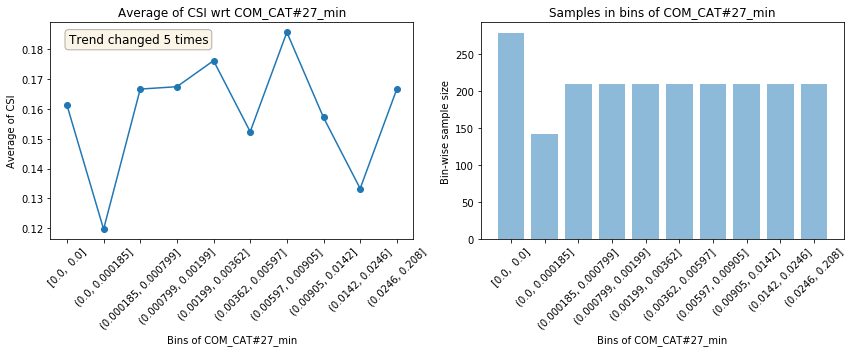

                                           Test data plots                                            


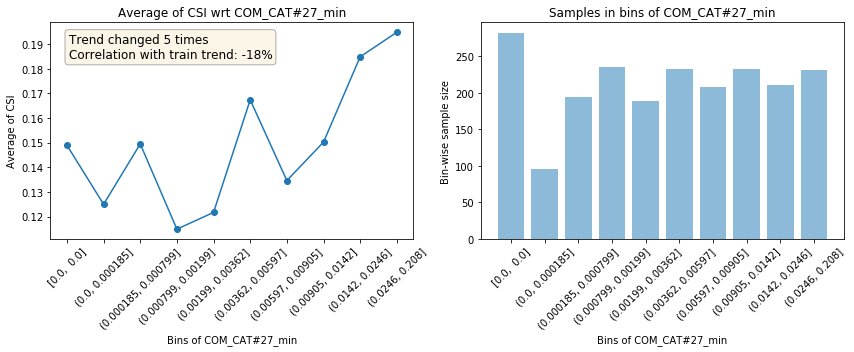

--------------------------------------------------------------------------------------------------------------


                                       Plots for COM_CAT#23_min                                       
                                           Train data plots                                           


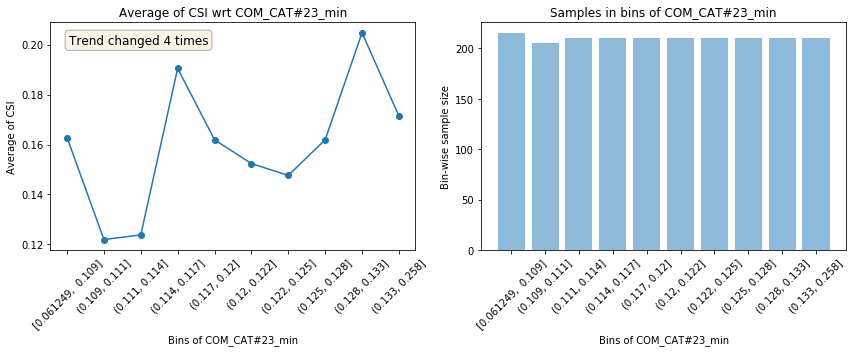

                                           Test data plots                                            


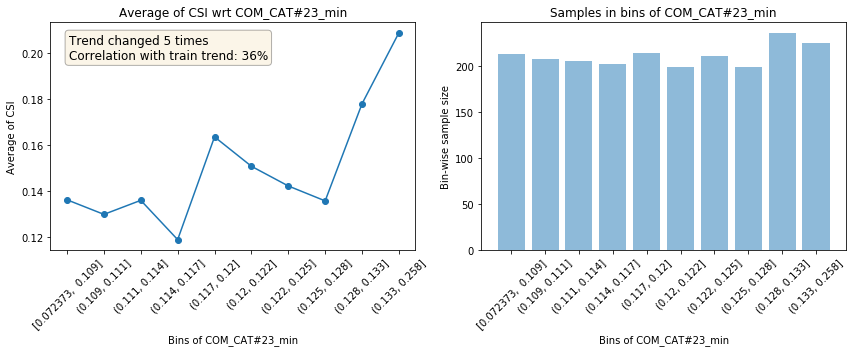

--------------------------------------------------------------------------------------------------------------


                                      Plots for RENT_CHANNEL_max                                      
                                           Train data plots                                           


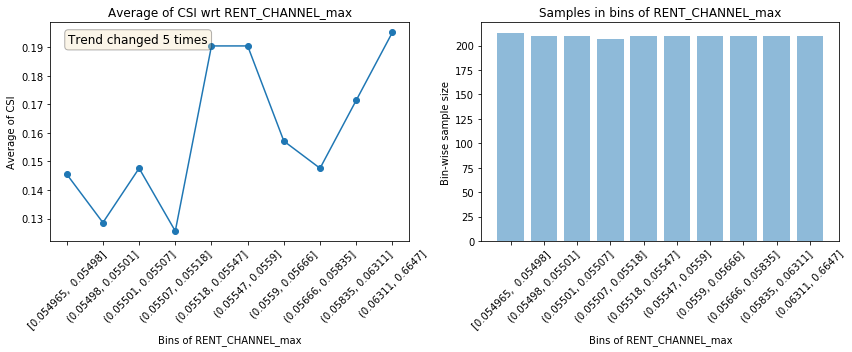

                                           Test data plots                                            


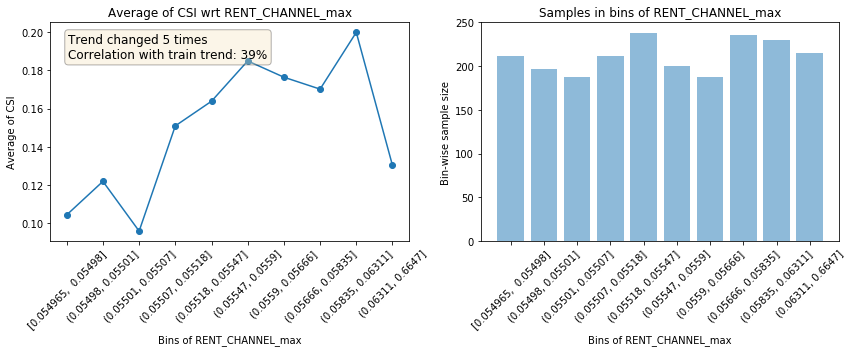

--------------------------------------------------------------------------------------------------------------


                                       Plots for COM_CAT#23_max                                       
                                           Train data plots                                           


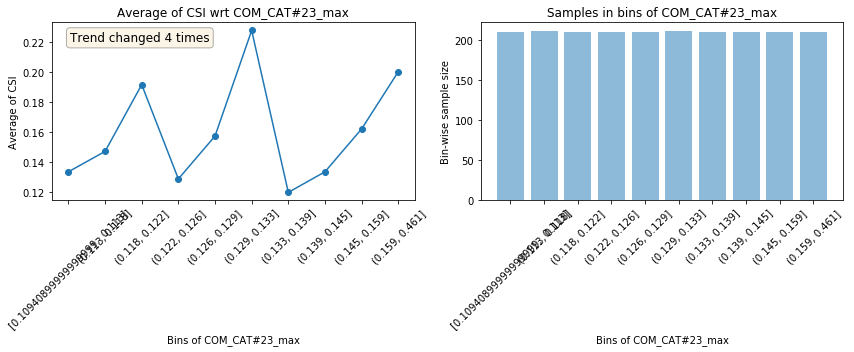

                                           Test data plots                                            


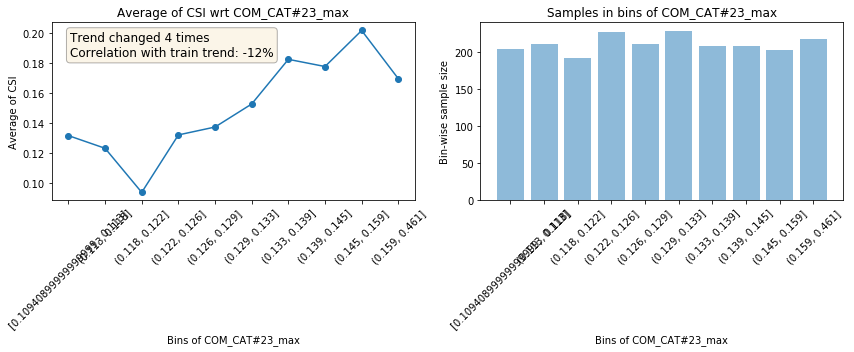

--------------------------------------------------------------------------------------------------------------


                                       Plots for COM_CAT#8_max                                        
                                           Train data plots                                           


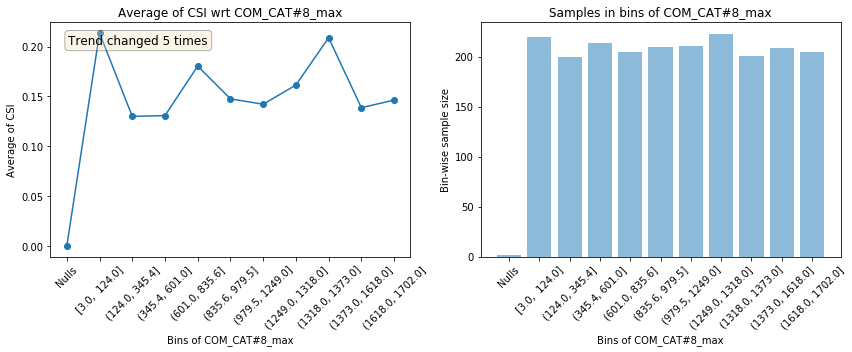

                                           Test data plots                                            


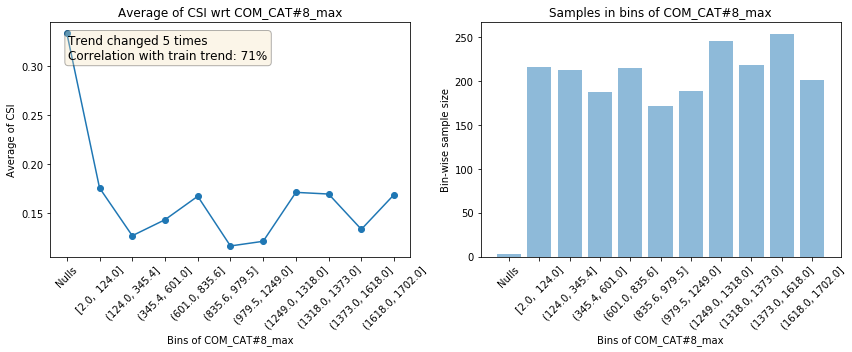

--------------------------------------------------------------------------------------------------------------


                                       Plots for COM_CAT#8_min                                        
                                           Train data plots                                           


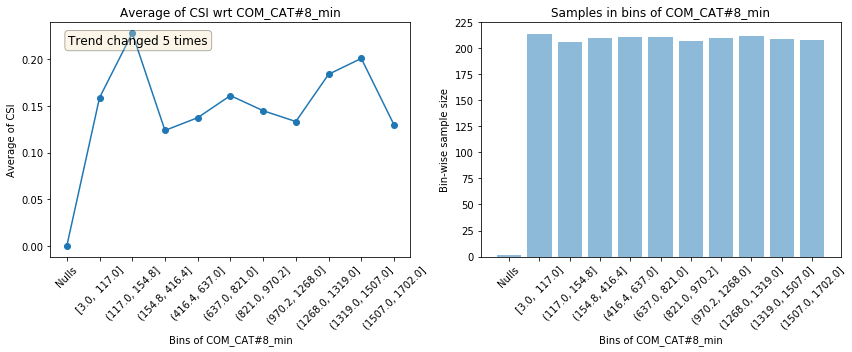

                                           Test data plots                                            


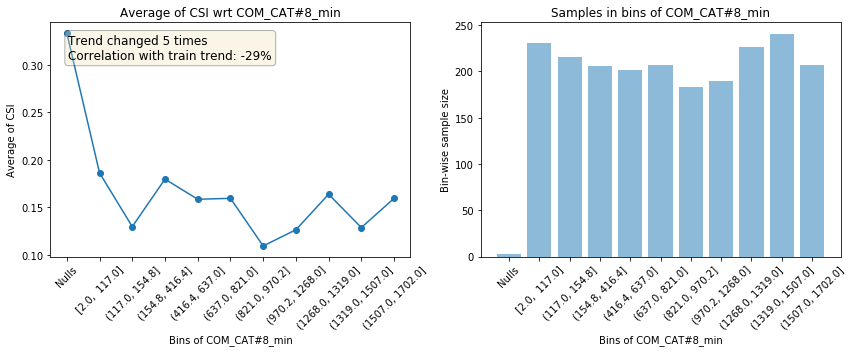

--------------------------------------------------------------------------------------------------------------


                                        Plots for REVENUE_max                                         
                                           Train data plots                                           


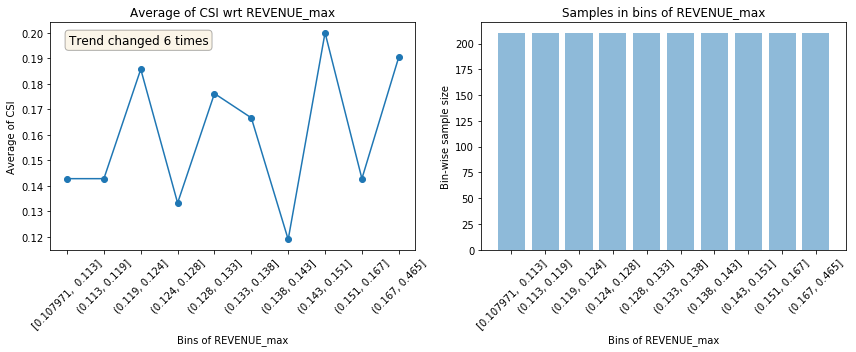

                                           Test data plots                                            


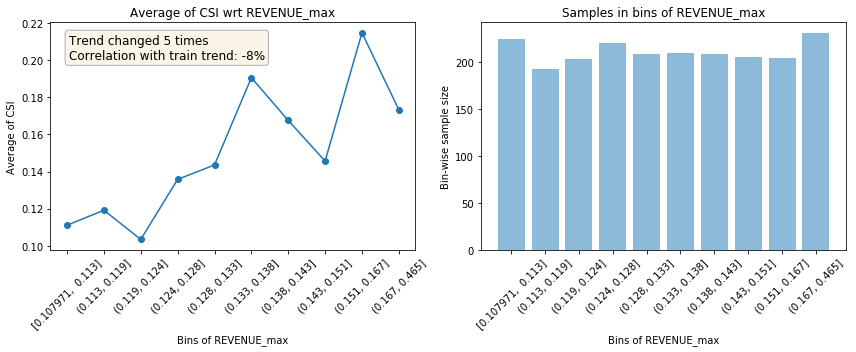

--------------------------------------------------------------------------------------------------------------


                                        Plots for REVENUE_mean                                        
                                           Train data plots                                           


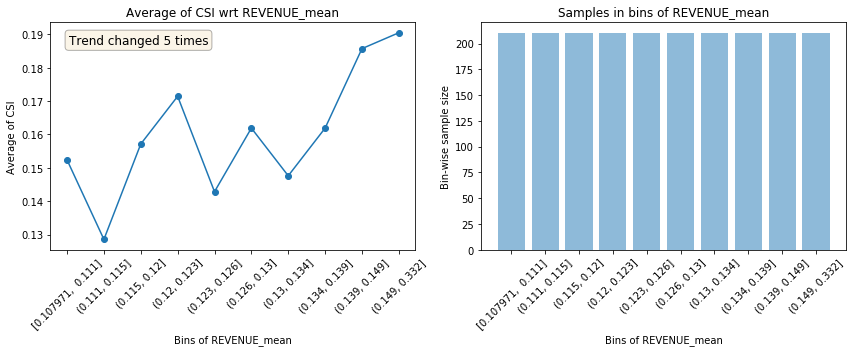

                                           Test data plots                                            


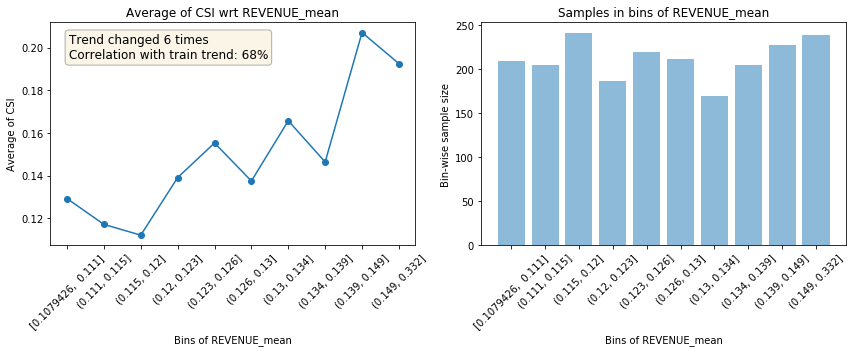

--------------------------------------------------------------------------------------------------------------


                                       Plots for COM_CAT#27_max                                       
                                           Train data plots                                           


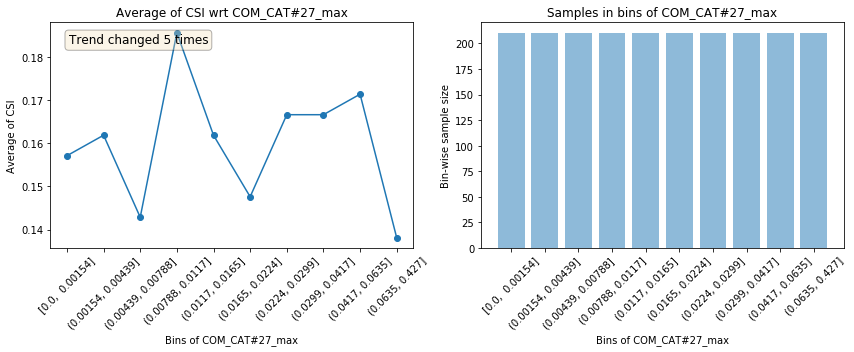

                                           Test data plots                                            


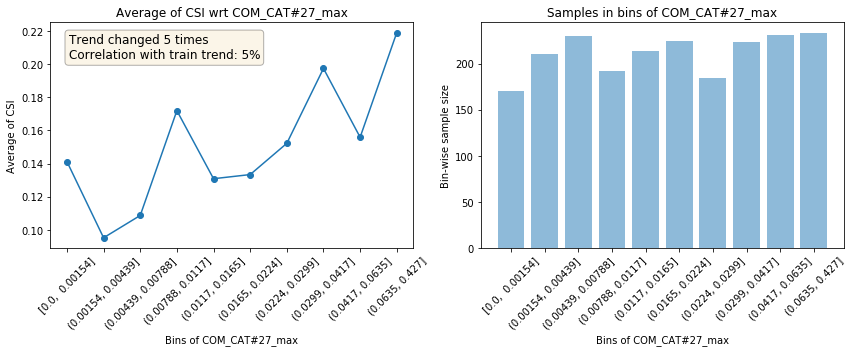

--------------------------------------------------------------------------------------------------------------


                                          Plots for COST_max                                          
                                           Train data plots                                           


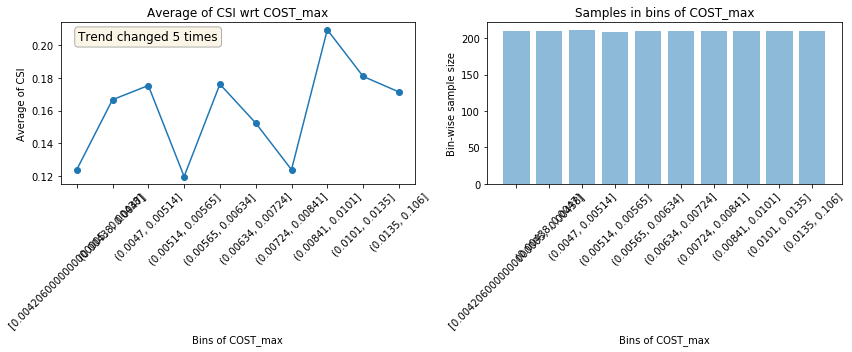

                                           Test data plots                                            


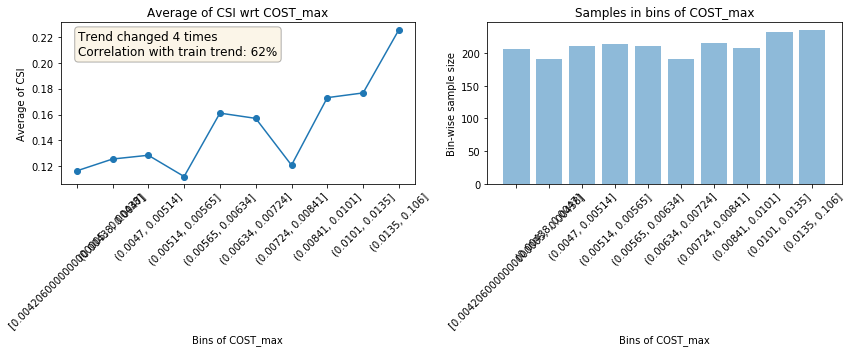

--------------------------------------------------------------------------------------------------------------


                                          Plots for VAS_max                                           
                                           Train data plots                                           


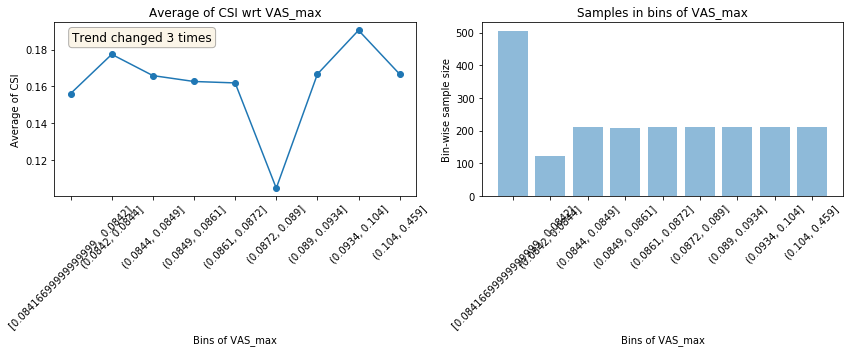

                                           Test data plots                                            


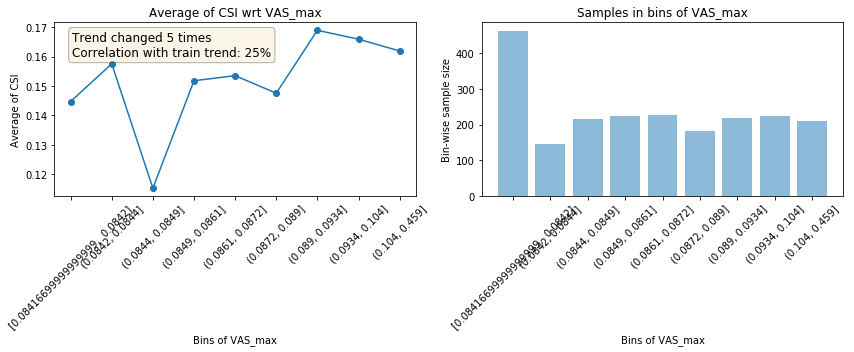

--------------------------------------------------------------------------------------------------------------


                                      Plots for COM_CAT#23_mean                                       
                                           Train data plots                                           


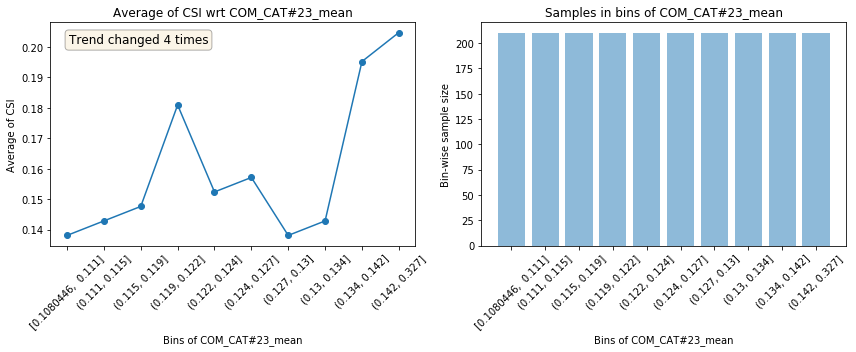

                                           Test data plots                                            


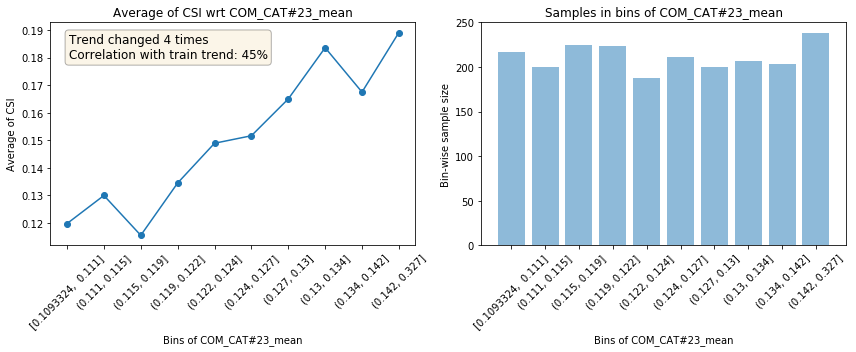

--------------------------------------------------------------------------------------------------------------


                                      Plots for COM_CAT#29_mean                                       
                                           Train data plots                                           


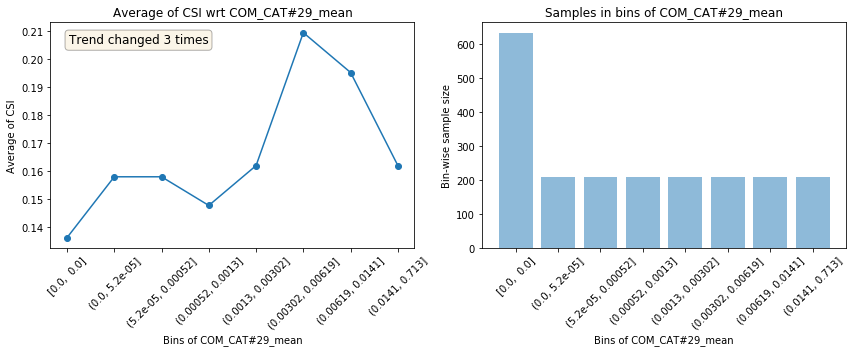

                                           Test data plots                                            


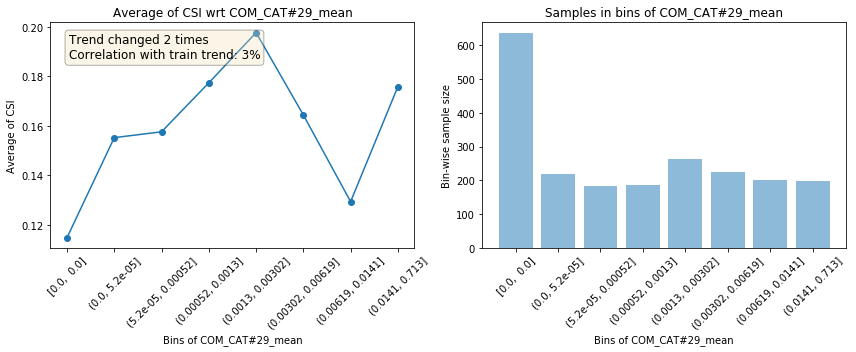

--------------------------------------------------------------------------------------------------------------


                                          Plots for COST_min                                          
                                           Train data plots                                           


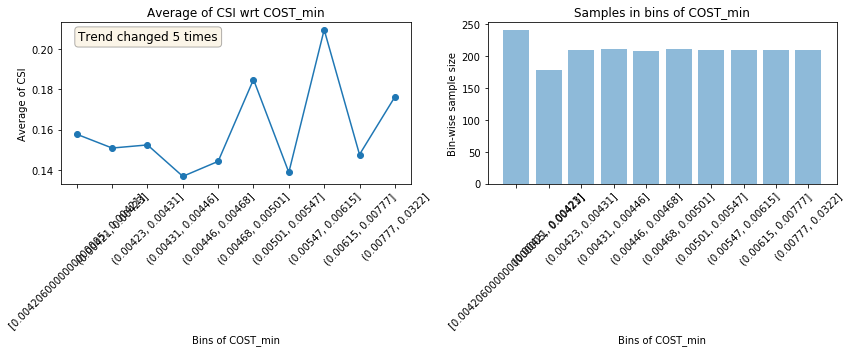

                                           Test data plots                                            


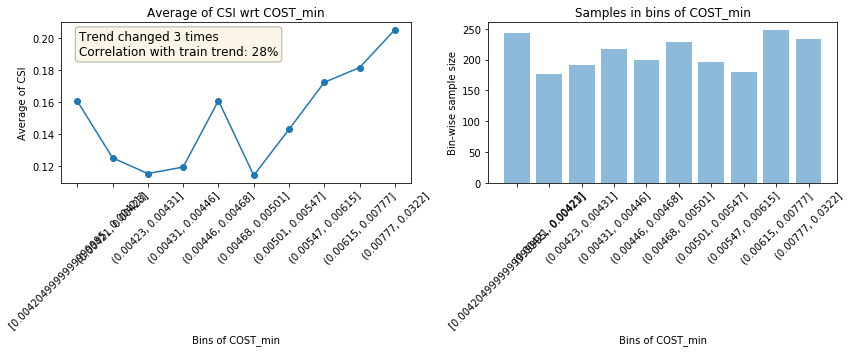

--------------------------------------------------------------------------------------------------------------


                                          Plots for VAS_mean                                          
                                           Train data plots                                           


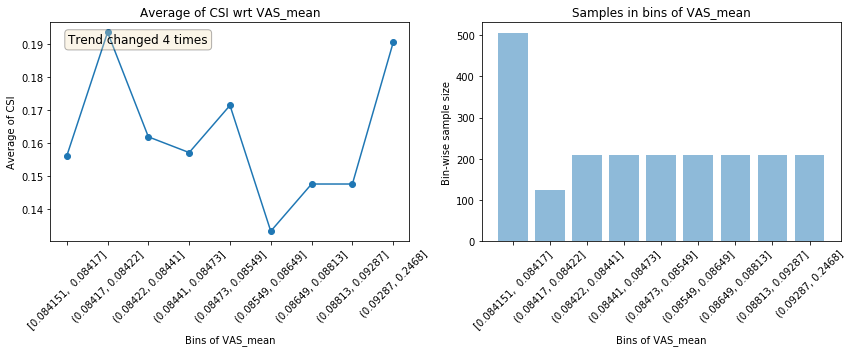

                                           Test data plots                                            


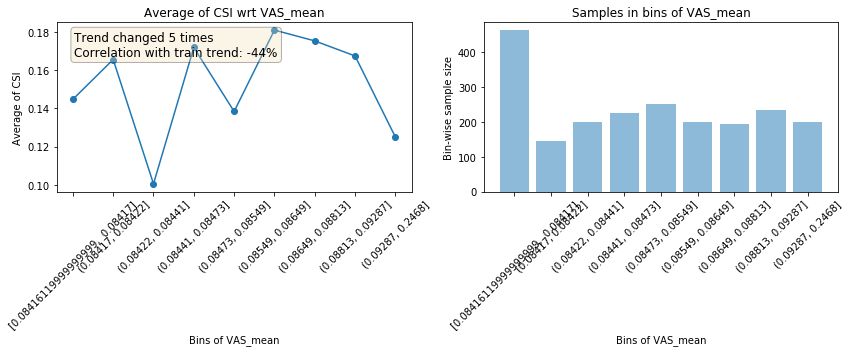

--------------------------------------------------------------------------------------------------------------


                                      Plots for RENT_CHANNEL_min                                      
                                           Train data plots                                           


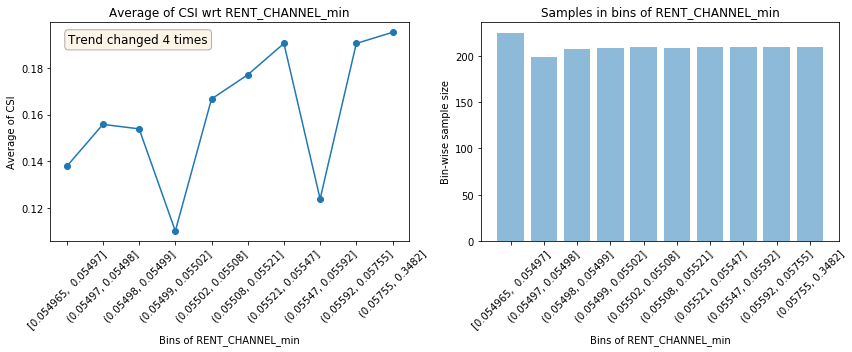

                                           Test data plots                                            


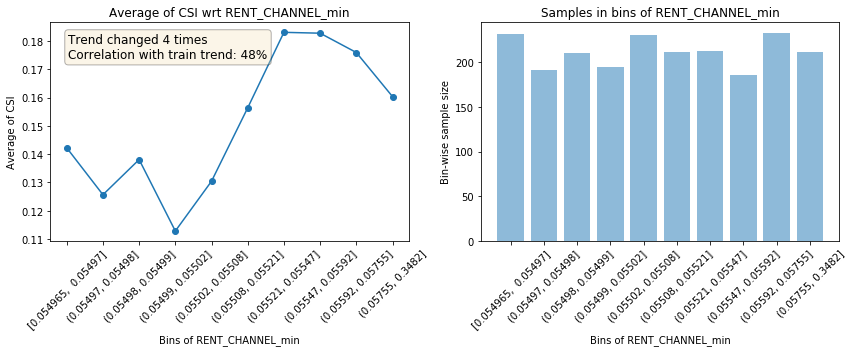

--------------------------------------------------------------------------------------------------------------


                                       Plots for COM_CAT#22_min                                       
                                           Train data plots                                           


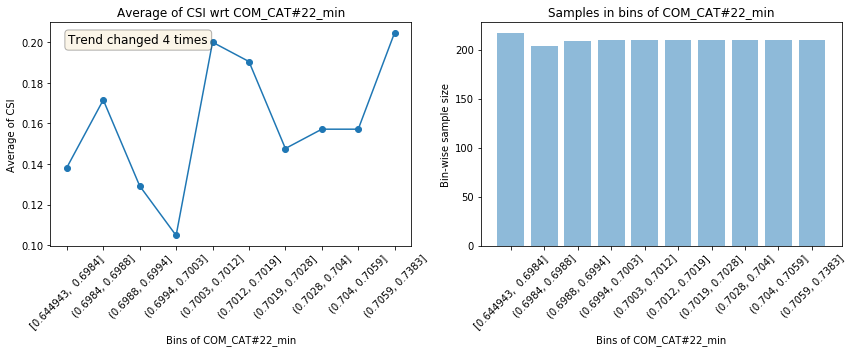

                                           Test data plots                                            


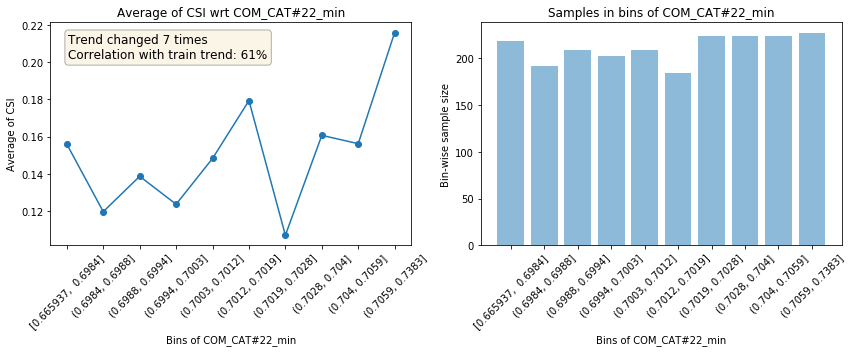

--------------------------------------------------------------------------------------------------------------


                                       Plots for COM_CAT#1_mean                                       
                                           Train data plots                                           


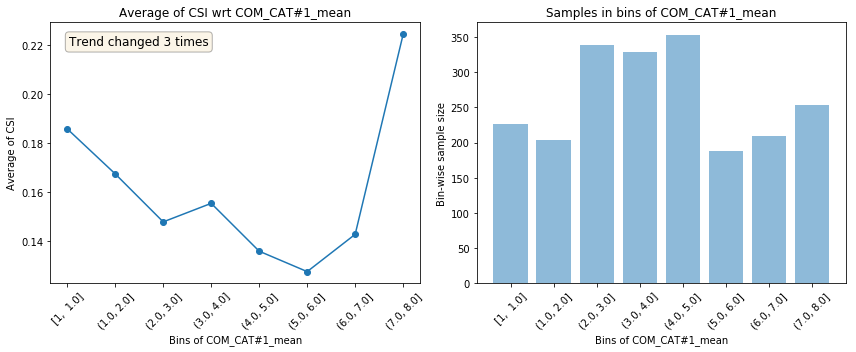

                                           Test data plots                                            


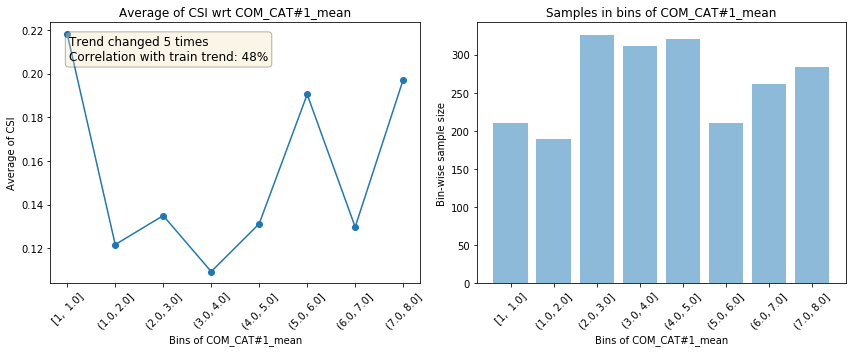

--------------------------------------------------------------------------------------------------------------


                                       Plots for COM_CAT#8_mean                                       
                                           Train data plots                                           


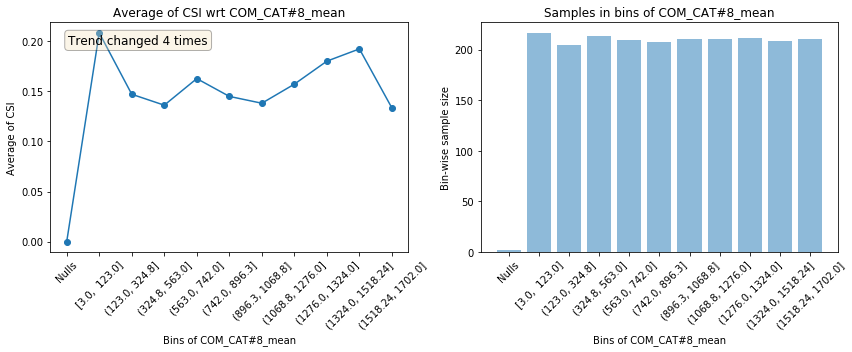

                                           Test data plots                                            


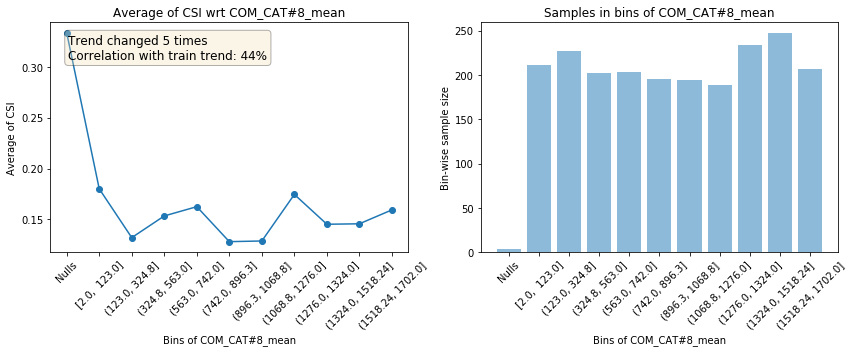

--------------------------------------------------------------------------------------------------------------


                                      Plots for COM_CAT#30_mean                                       
                                           Train data plots                                           


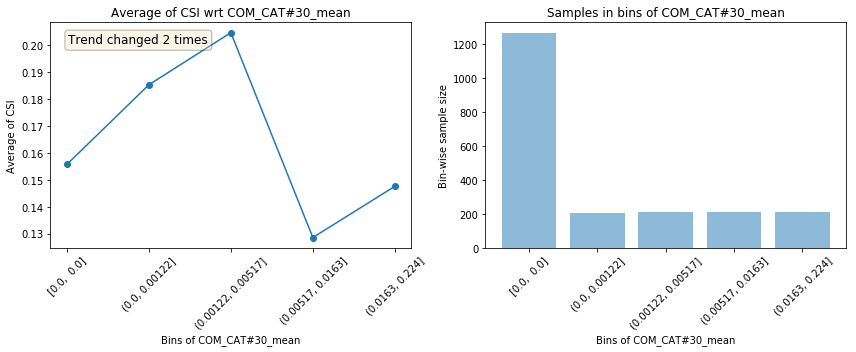

                                           Test data plots                                            


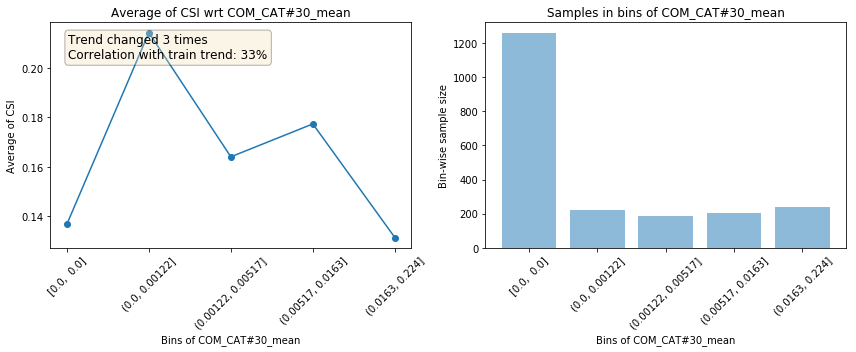

--------------------------------------------------------------------------------------------------------------


                                      Plots for COM_CAT#27_mean                                       
                                           Train data plots                                           


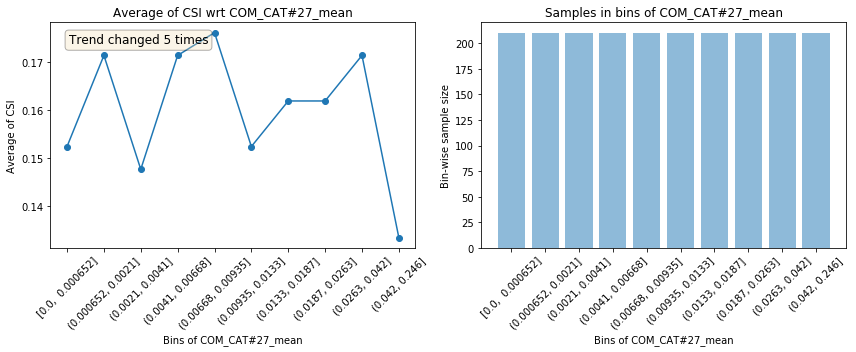

                                           Test data plots                                            


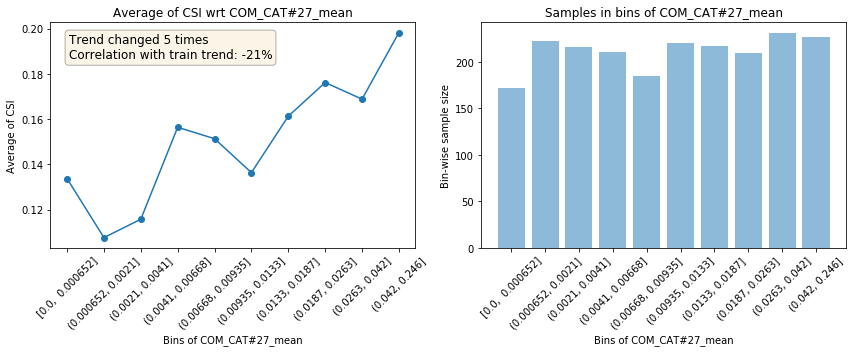

--------------------------------------------------------------------------------------------------------------


                                       Plots for COM_CAT#29_min                                       
                                           Train data plots                                           


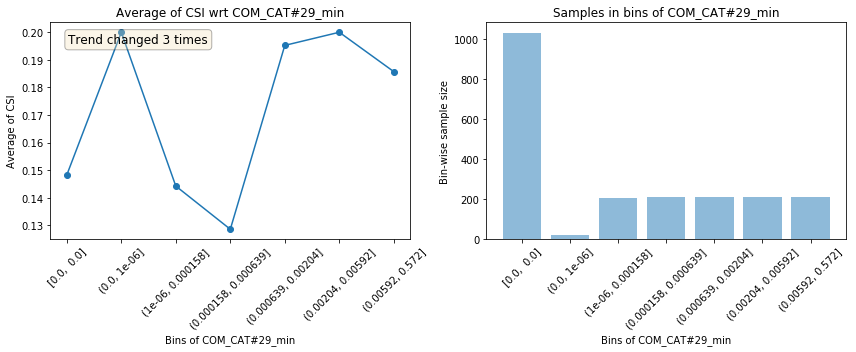

                                           Test data plots                                            


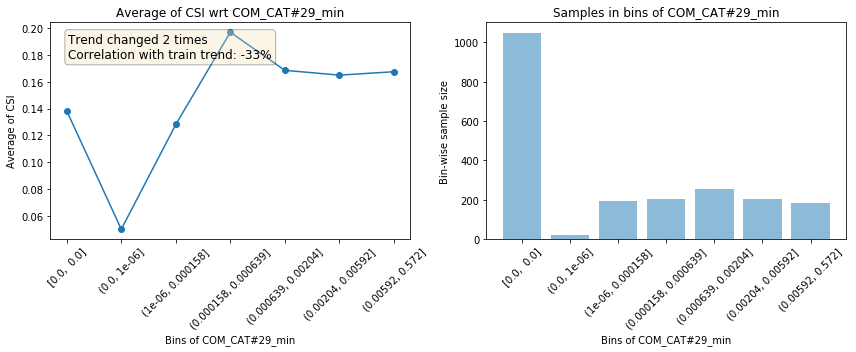

--------------------------------------------------------------------------------------------------------------


                                          Plots for ITC_min                                           
                                           Train data plots                                           


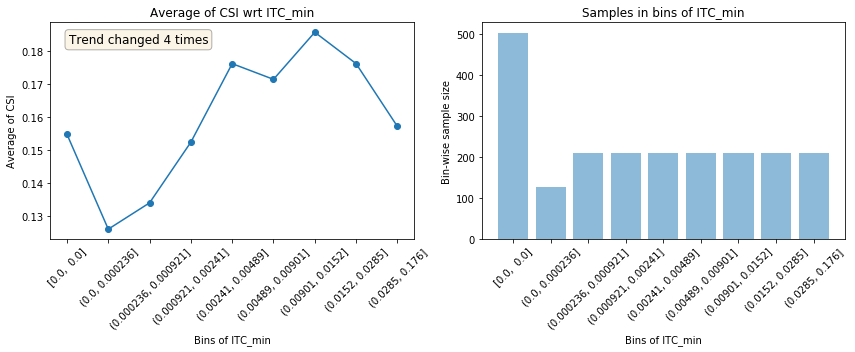

                                           Test data plots                                            


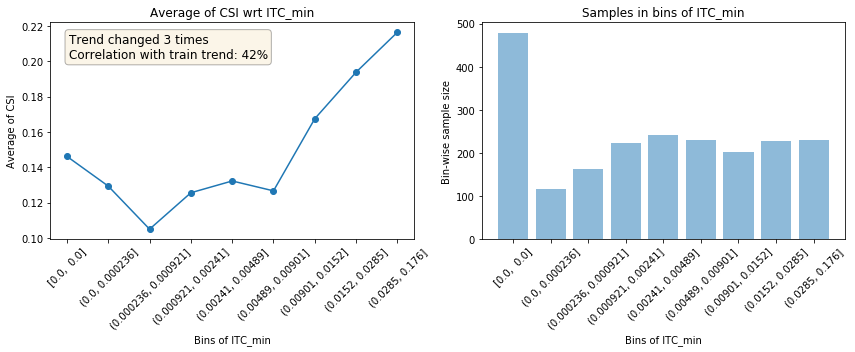

--------------------------------------------------------------------------------------------------------------


                                       Plots for COM_CAT#20_min                                       
                                           Train data plots                                           


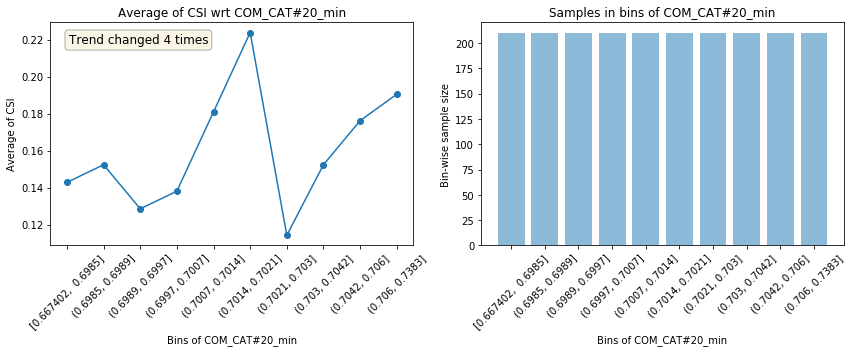

                                           Test data plots                                            


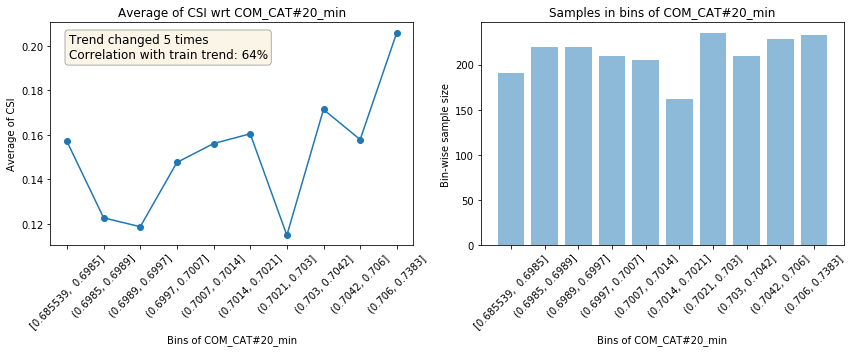

--------------------------------------------------------------------------------------------------------------


                                       Plots for COM_CAT#22_max                                       
                                           Train data plots                                           


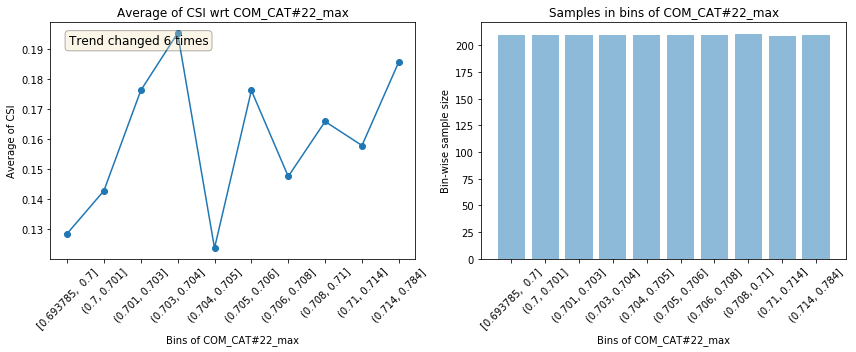

                                           Test data plots                                            


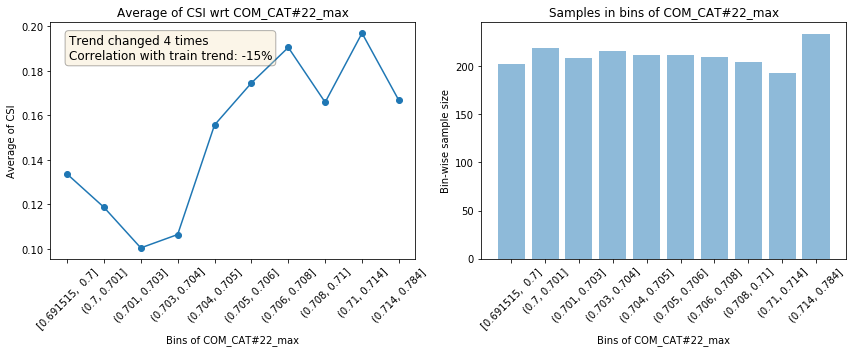

--------------------------------------------------------------------------------------------------------------


                                          Plots for ITC_max                                           
                                           Train data plots                                           


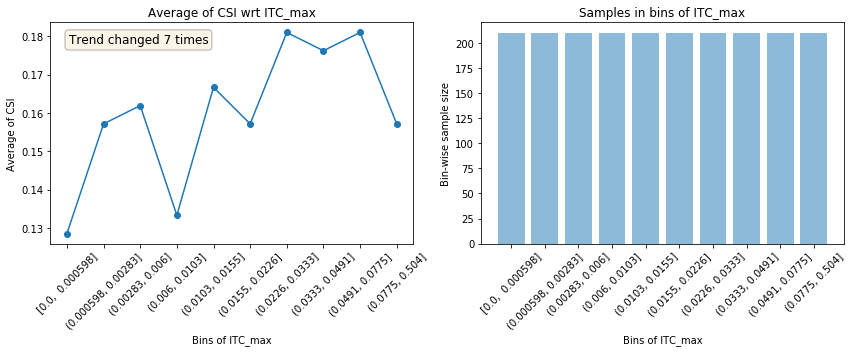

                                           Test data plots                                            


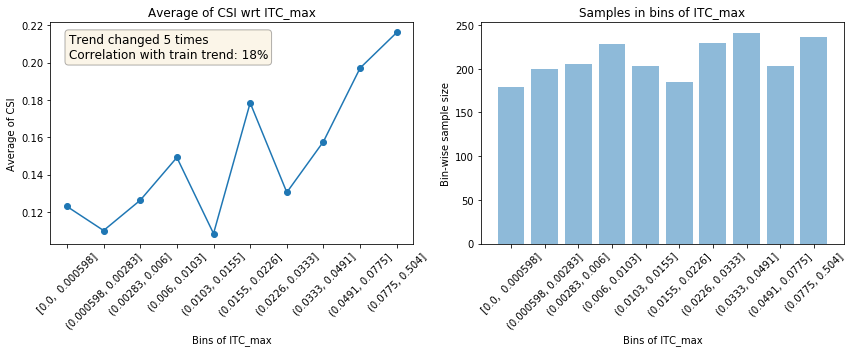

--------------------------------------------------------------------------------------------------------------


                                          Plots for VAS_min                                           
                                           Train data plots                                           


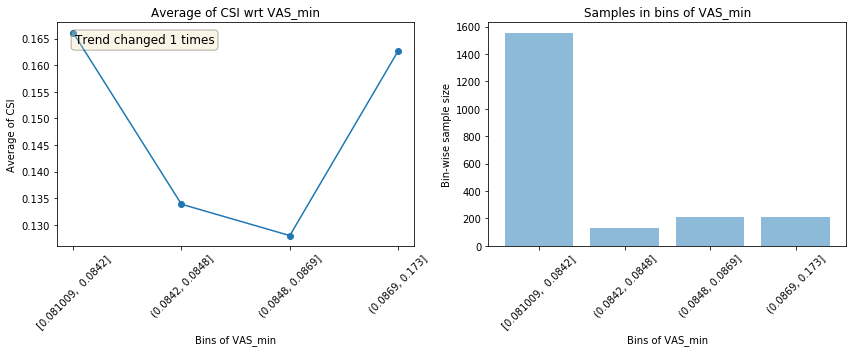

                                           Test data plots                                            


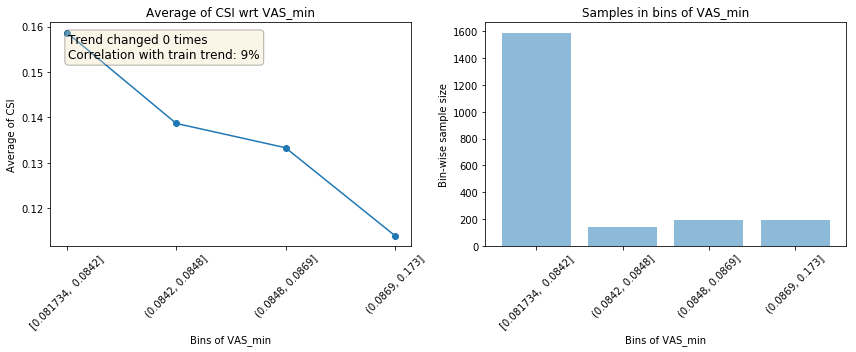

--------------------------------------------------------------------------------------------------------------


                                      Plots for COM_CAT#31_mean                                       
                                           Train data plots                                           


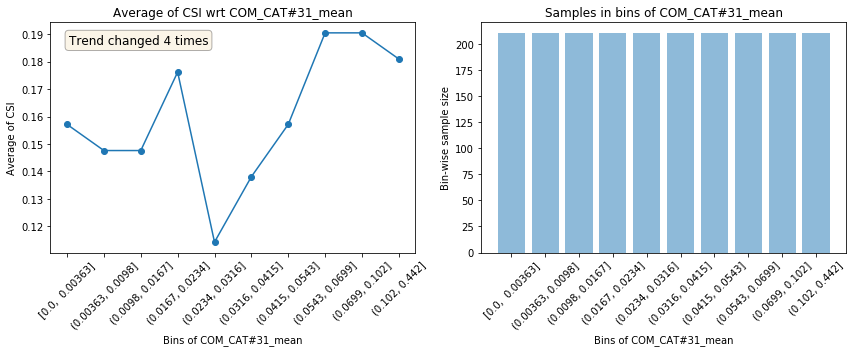

                                           Test data plots                                            


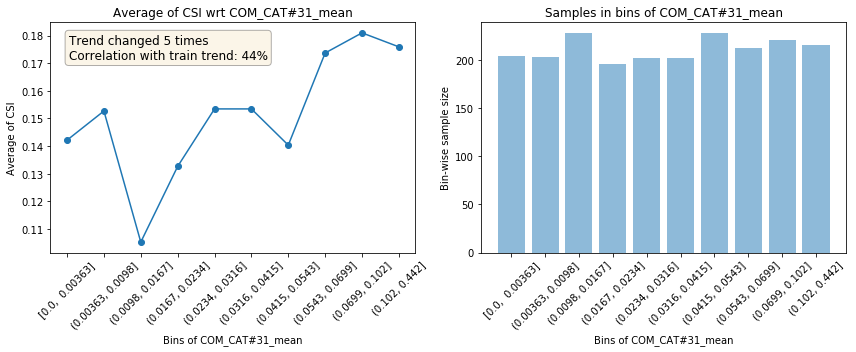

--------------------------------------------------------------------------------------------------------------


                                      Plots for COM_CAT#20_mean                                       
                                           Train data plots                                           


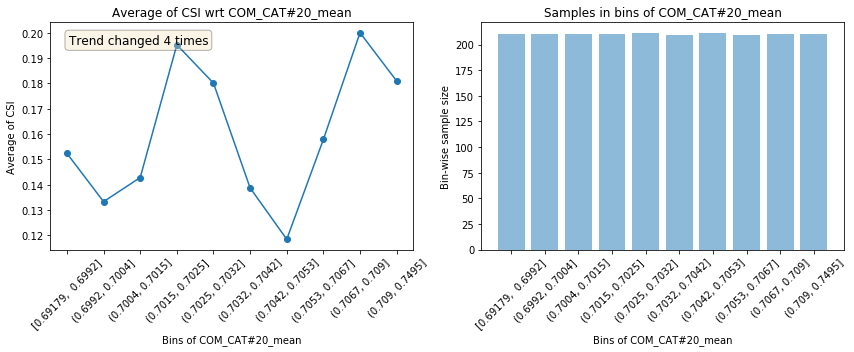

                                           Test data plots                                            


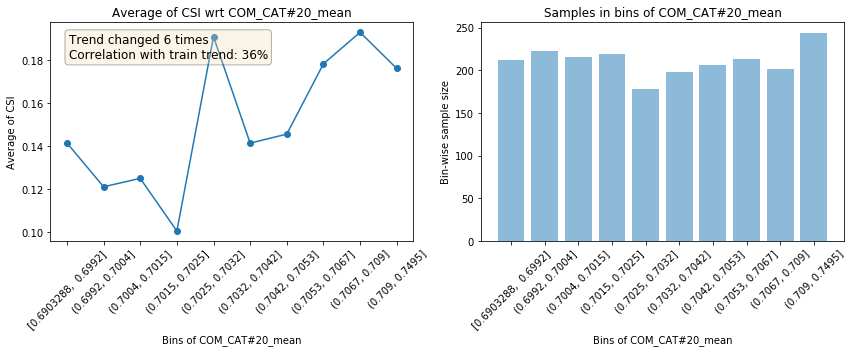

--------------------------------------------------------------------------------------------------------------


                                       Plots for COM_CAT#29_max                                       
                                           Train data plots                                           


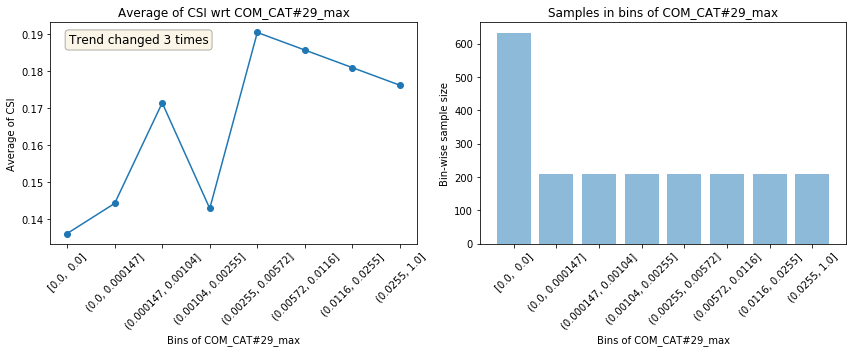

                                           Test data plots                                            


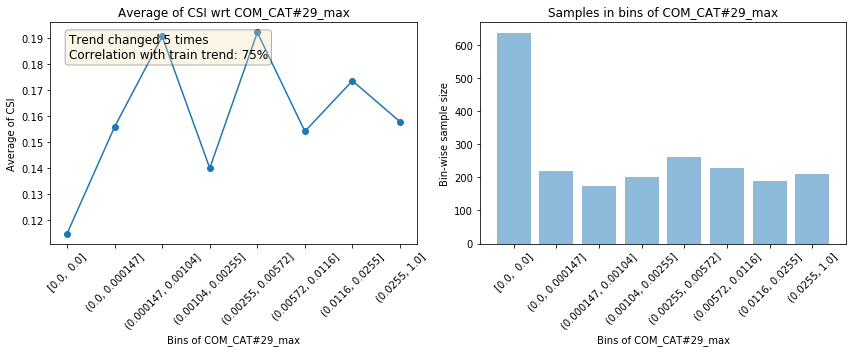

--------------------------------------------------------------------------------------------------------------


                                      Plots for COM_CAT#17_mean                                       
                                           Train data plots                                           


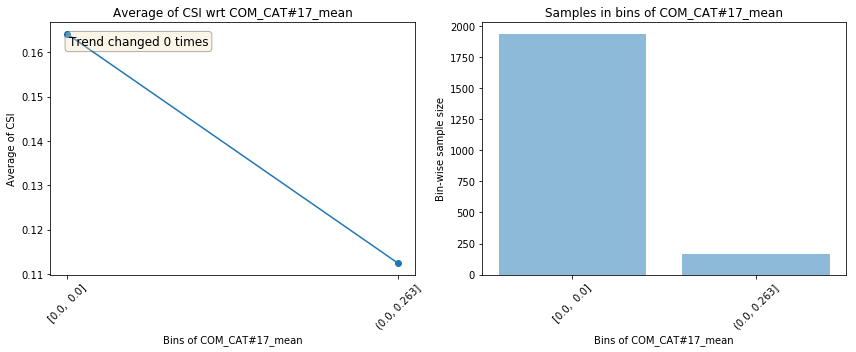

                                           Test data plots                                            


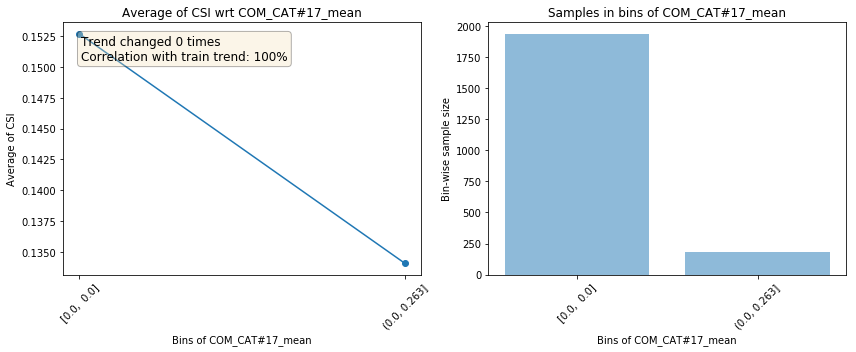

--------------------------------------------------------------------------------------------------------------


                                       Plots for COM_CAT#20_max                                       
                                           Train data plots                                           


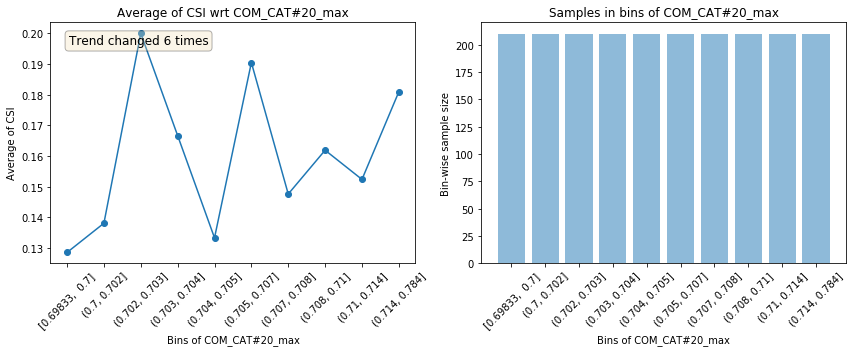

                                           Test data plots                                            


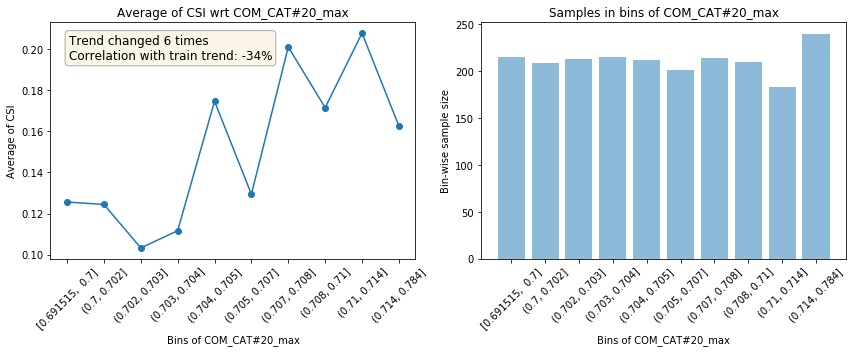

--------------------------------------------------------------------------------------------------------------


                                       Plots for COM_CAT#30_min                                       
                                           Train data plots                                           


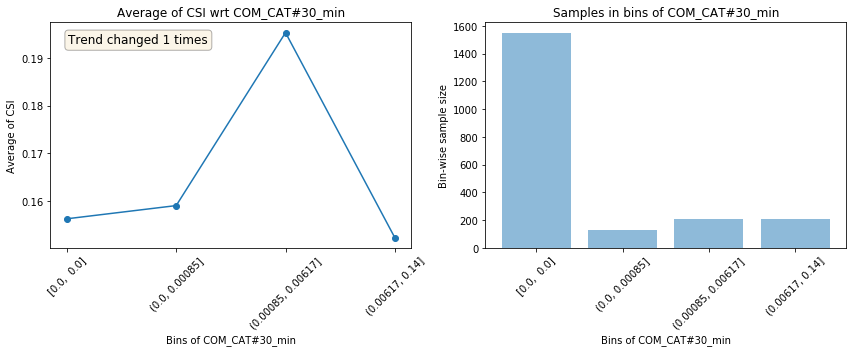

                                           Test data plots                                            


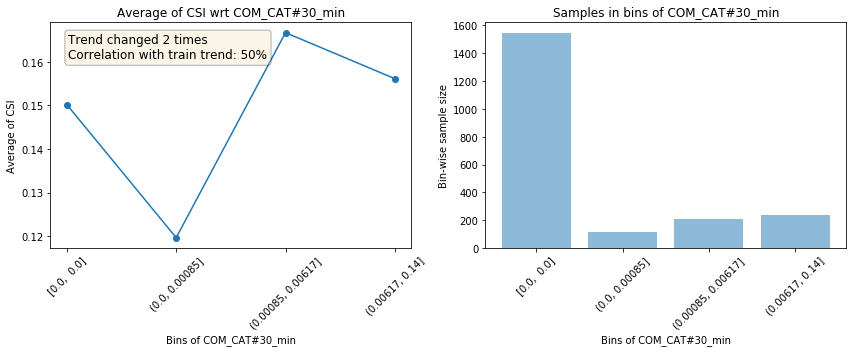

--------------------------------------------------------------------------------------------------------------


                                        Plots for REVENUE_min                                         
                                           Train data plots                                           


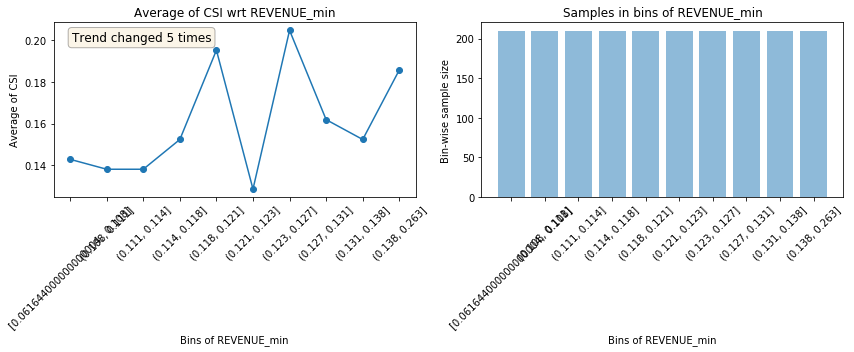

                                           Test data plots                                            


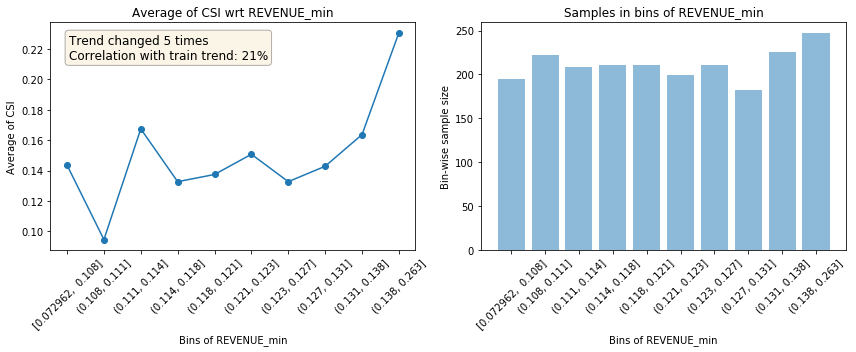

--------------------------------------------------------------------------------------------------------------


                                       Plots for COM_CAT#30_max                                       
                                           Train data plots                                           


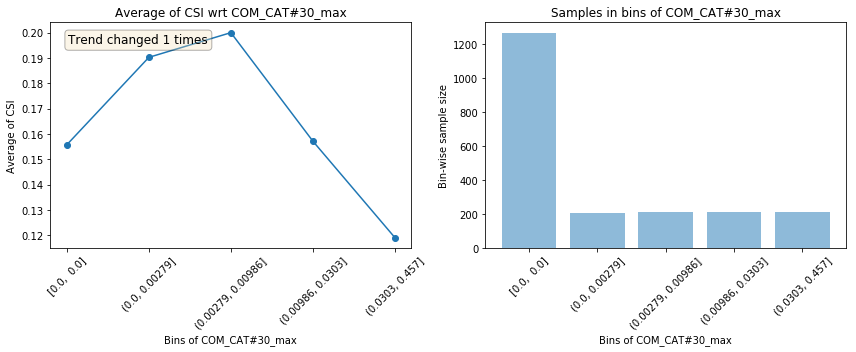

                                           Test data plots                                            


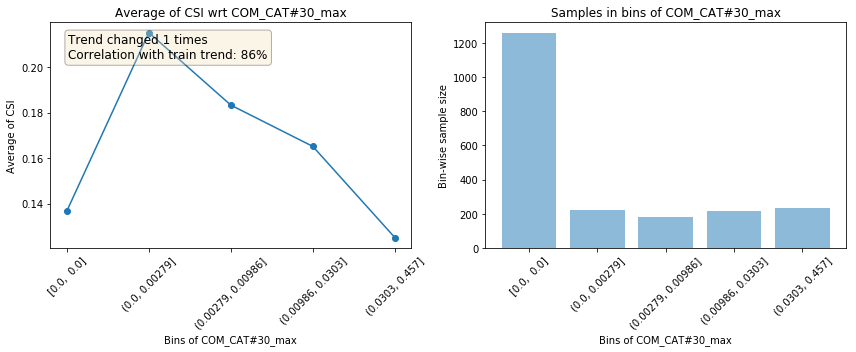

--------------------------------------------------------------------------------------------------------------


                                      Plots for COM_CAT#22_mean                                       
                                           Train data plots                                           


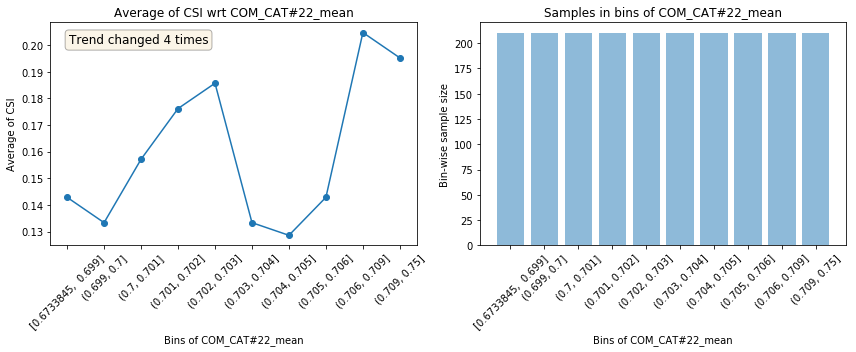

                                           Test data plots                                            


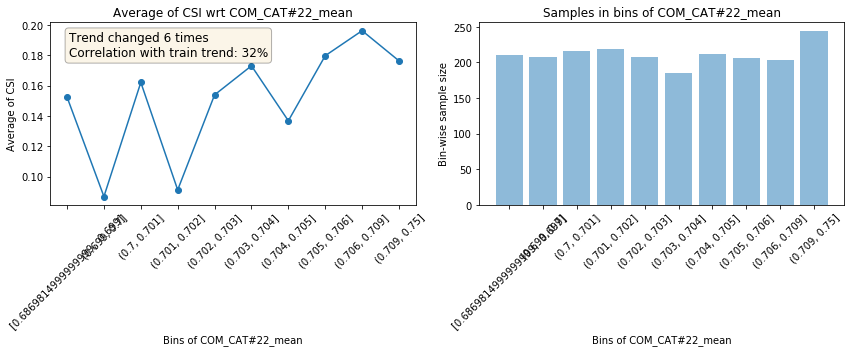

--------------------------------------------------------------------------------------------------------------


                                       Plots for COM_CAT#28_max                                       
                                           Train data plots                                           


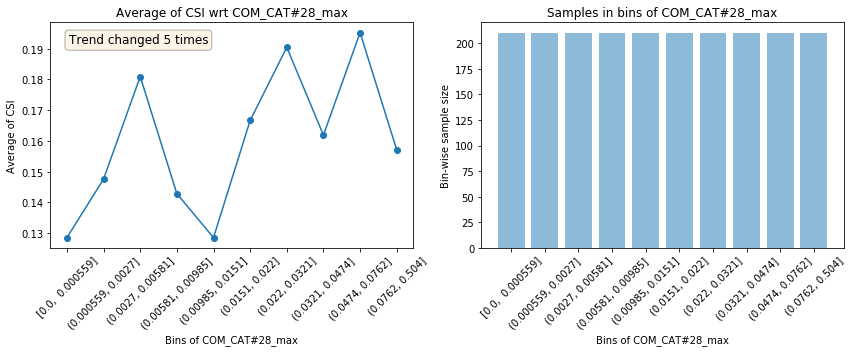

                                           Test data plots                                            


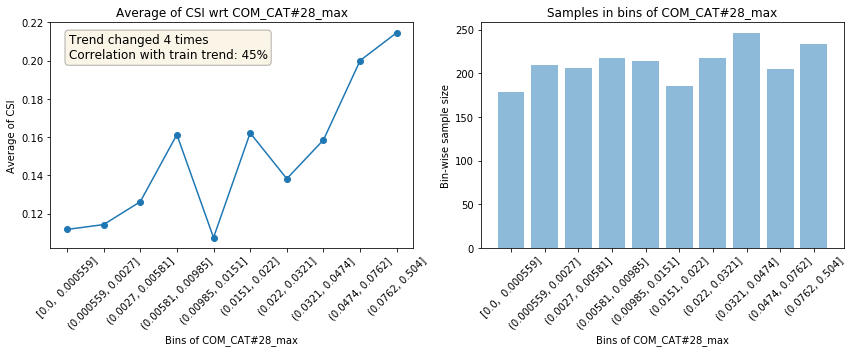

--------------------------------------------------------------------------------------------------------------


                                      Plots for COM_CAT#33_mean                                       
                                           Train data plots                                           


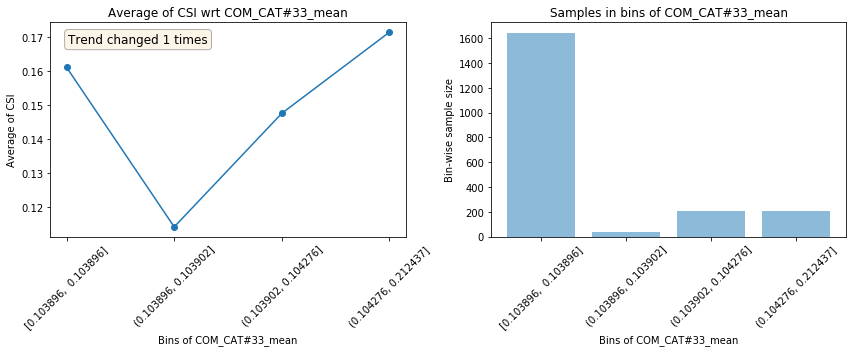

                                           Test data plots                                            


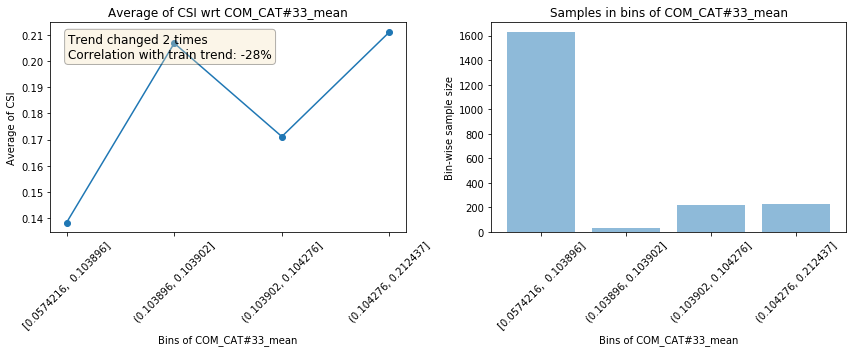

--------------------------------------------------------------------------------------------------------------


                                      Plots for COM_CAT#32_mean                                       


ValueError: bins must increase monotonically.

In [192]:
get_univariate_plots(data=raw_tr, target_col='CSI', features_list=to_keep, data_test=raw_val)

In [186]:
m = lgb.LGBMClassifier()
m.fit(X_train, y_train)
print_score(m)

[0.9999757084421613, 0.5010187810063784, 0.968266456858117, 0.83]


In [188]:
m = RandomForestClassifier(n_jobs=-1, n_estimators=10, 
                            oob_score=True)
m.fit(X_train, y_train)
print_score(m)

/Users/alexeydemyanchuk/.virtualenvs/kaggle_env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexeydemyanchuk/.virtualenvs/kaggle_env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[0.999681569361375, 0.4646748759744862, 0.975609756097561, 0.8275, 0.8075006556517178]



#### T statistics 

In [94]:
m = RandomForestClassifier(n_jobs=-1, n_estimators=10)
m.fit(X_train, y_train)
print_score(m)

[0.9995930263361565, 0.521672549833887, 0.976921059533176, 0.8525]


In [95]:
m = lgb.LGBMClassifier()
m.fit(X_train, y_train)
print_score(m)

[0.9999470181063024, 0.5350913621262459, 0.971938106477839, 0.8525]


In [347]:
m_A = lgb.LGBMClassifier()

In [348]:
m_B = lgb.LGBMClassifier()

In [349]:
scoring =  metrics.make_scorer(metrics.roc_auc_score, needs_proba=True)

scores_A = np.array([])
scores_B = np.array([])

In [350]:
for i in range(10):
    fold = sklearn.model_selection.KFold(
        n_splits=5, shuffle=True, random_state=i)

    current_scores_A = sklearn.model_selection.cross_val_score(
        estimator=m_A, X=df, y=y, cv=fold, scoring=scoring, n_jobs=-1)

    scores_A = np.append(scores_A, current_scores_A)

    current_scores_B = sklearn.model_selection.cross_val_score(
        estimator=m_B, X=df_other, y=y_other, cv=fold, scoring=scoring, n_jobs=-1)

    scores_B = np.append(scores_B, current_scores_B)
    
ttest_rel(scores_A, scores_B)

Ttest_relResult(statistic=-0.5254235366522199, pvalue=0.6016584866362571)

In [351]:
scores_A.mean(), scores_A.std()

(0.5228746688409873, 0.023085679503201235)

In [352]:
scores_B.mean(), scores_B.std()

(0.5253093282096019, 0.023421618320005416)

 - last 5 months vs full data `Ttest_relResult(statistic=-0.5739371988382607, pvalue=0.5686356084768682)`
 - last 5 months vs last 8 months `Ttest_relResult(statistic=0.6013845705864069, pvalue=0.5503561387167131)`
 - last 5 months vs last 3 months `Ttest_relResult(statistic=0.7411994751002573, pvalue=0.46211007794300796)`
 - last 5 months vs last 1 month `Ttest_relResult(statistic=0.23439294381926984, pvalue=0.8156565977942658)`
 - **last 5 months vs first 7 months** `Ttest_relResult(statistic=-4.606351117888431, pvalue=2.940069851986962e-05)`
 - last 5 months vs Nov-Mar `Ttest_relResult(statistic=0.538136115643363, pvalue=0.5929192015989826)`
 - last 5 months vs first 10 months `Ttest_relResult(statistic=-0.5254235366522199, pvalue=0.6016584866362571)`
 - **last 5 months vs Jan-Mar** `Ttest_relResult(statistic=4.410632452196336, pvalue=5.6370093653997715e-05)`
 - **last 5 months vs last 2 months** `Ttest_relResult(statistic=1.9717617159255272, pvalue=0.05429614296591497)`

In [381]:
# TODO: try prediction from first 7 months on LB!!!

In [378]:
# in case you allready have scores_A
m_B = lgb.LGBMClassifier()
scoring =  metrics.make_scorer(metrics.roc_auc_score, needs_proba=True)
scores_B = np.array([])

for i in range(10):
    fold = sklearn.model_selection.KFold(
        n_splits=5, shuffle=True, random_state=i)

    current_scores_B = sklearn.model_selection.cross_val_score(
        estimator=m_B, X=df_other, y=y_other, cv=fold, scoring=scoring, n_jobs=-1)

    scores_B = np.append(scores_B, current_scores_B)
    
ttest_rel(scores_A, scores_B)

Ttest_relResult(statistic=1.9717617159255272, pvalue=0.05429614296591497)

In [379]:
scores_A.mean(), scores_A.std()

(0.5228746688409873, 0.023085679503201235)

In [380]:
scores_B.mean(), scores_B.std()

(0.514333598448259, 0.02480180401465646)

#### Cross-val predict

In [218]:
m = lgb.LGBMClassifier()

In [219]:
scoring =  {'roc_auc': metrics.make_scorer(metrics.roc_auc_score, needs_proba=True)}

In [220]:
scores = sklearn.model_selection.cross_validate(
    m, df_keep, y, cv=5, scoring=scoring,
    return_train_score=True, return_estimator=True)

In [221]:
scores['train_roc_auc'].mean(), scores['train_roc_auc'].std()*2

(0.9999965134955684, 9.53572754637534e-06)

In [222]:
scores['test_roc_auc'].mean(), scores['test_roc_auc'].std()*2

(0.5443695881404405, 0.03244933620617326)

In [223]:
pred_y = np.zeros(len(test))
for est in scores['estimator']:
    pred_y += est.predict_proba(test[to_keep])[:,1] / 5

### Predict on test and submit

In [58]:
m = RandomForestClassifier(n_jobs=-1, n_estimators=100, min_samples_leaf=12, max_features=0.8, 
                           random_state=111)
m.fit(df, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.8, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=12, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=111, verbose=0, warm_start=False)

In [173]:
m = lgb.LGBMClassifier()
m.fit(df, y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=31, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

In [59]:
pred_y = m.predict_proba(test)[:,1]

In [224]:
subm = pd.DataFrame(pred_y)

In [225]:
subm.shape

(5221, 1)

In [226]:
subm.to_csv('submits/lgb_t-test_val_fi55.csv', index=False, header=False)